In [1]:
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


from gudhi import bottleneck_distance
import pandas as pd

In [2]:
import os, sys
sys.path.append("..")

from src.toy_functions import Alpine01, HumpCamel6, PenHolder, Langermann, Schwefel26, Tripod, HolderTable, UrsemWaves, Wavy, XinSheYang04
from src.tools import HNSWNearestNeighbors
from src.tools import make_undirected, make_rectangular
from src.tools import plot_graph, plot_barcodes
from src.sublevel import graph as GetBarcodes

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

## Visualising complex 2D functions and computing their barcodes

In [4]:
OUT_PATH = 'toy_results_2d'

if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

N = 10000000
x = np.random.rand(N, 2)
graph = np.array(HNSWNearestNeighbors(x, k=4)[0], dtype=np.int32)

fs_and_tops = [
    (Langermann(), 30),
    (Alpine01(), 49),
    (HumpCamel6(), 6),
    (Tripod(), 3),
    (PenHolder(), 49),
    (Schwefel26(), 49),
    (HolderTable(), 49),
    (UrsemWaves(), 8),
    (Wavy(), 49),
    (XinSheYang04(), 49),
]

/home/akorotin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


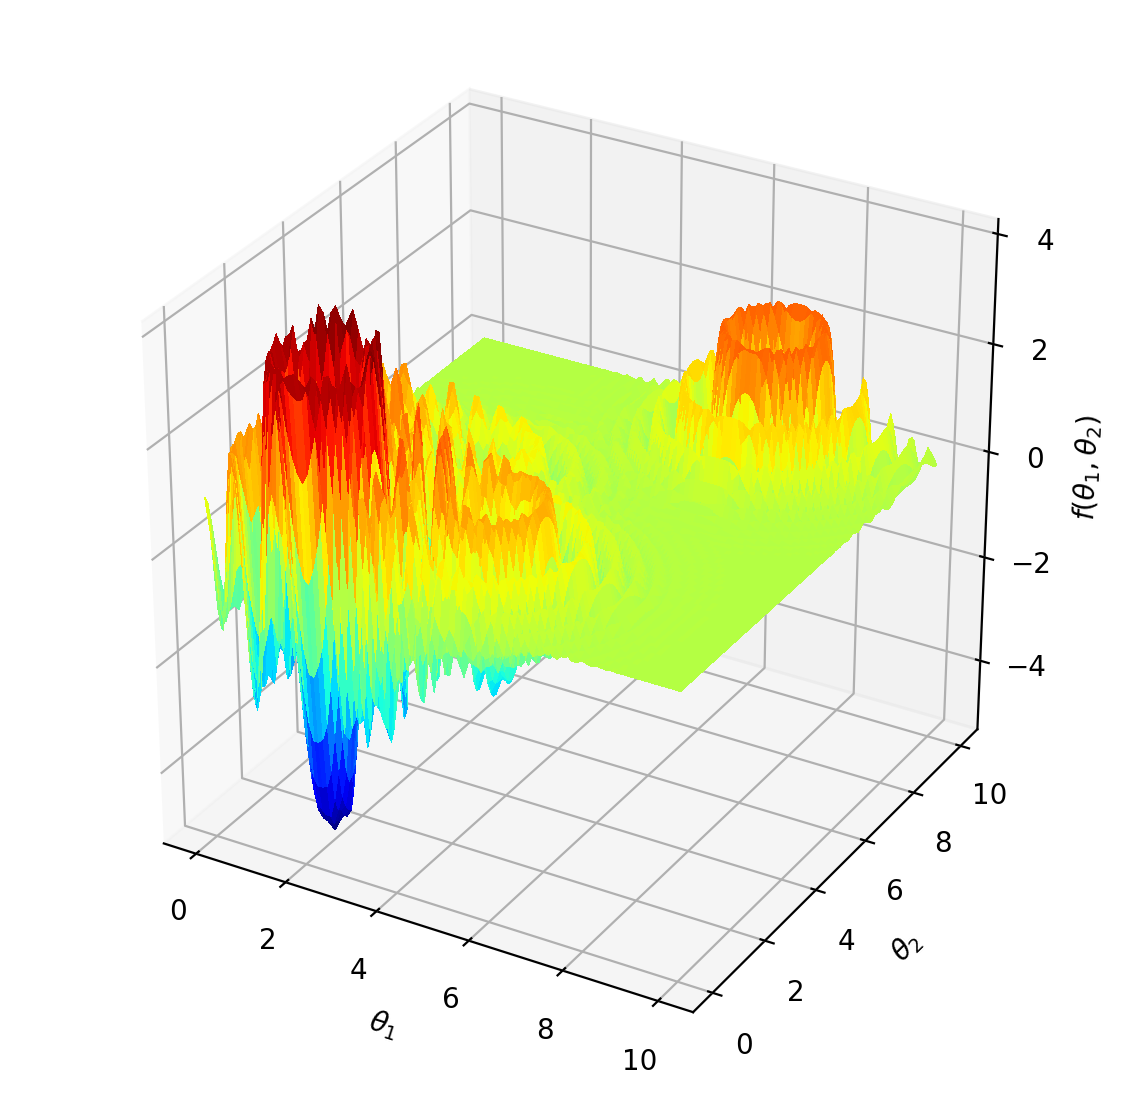

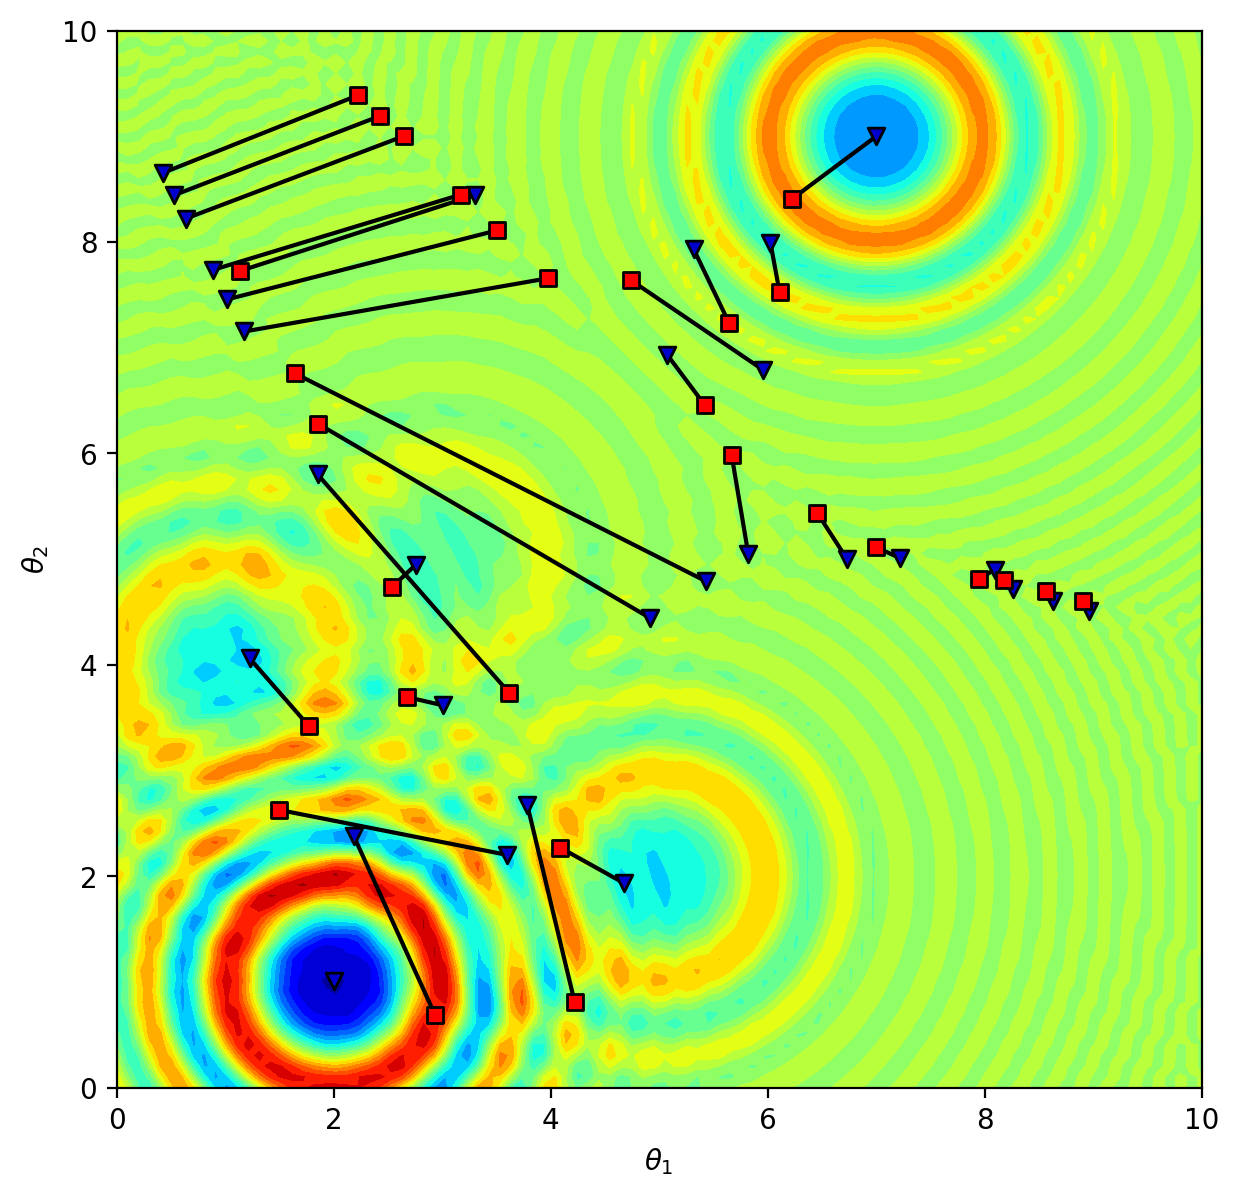

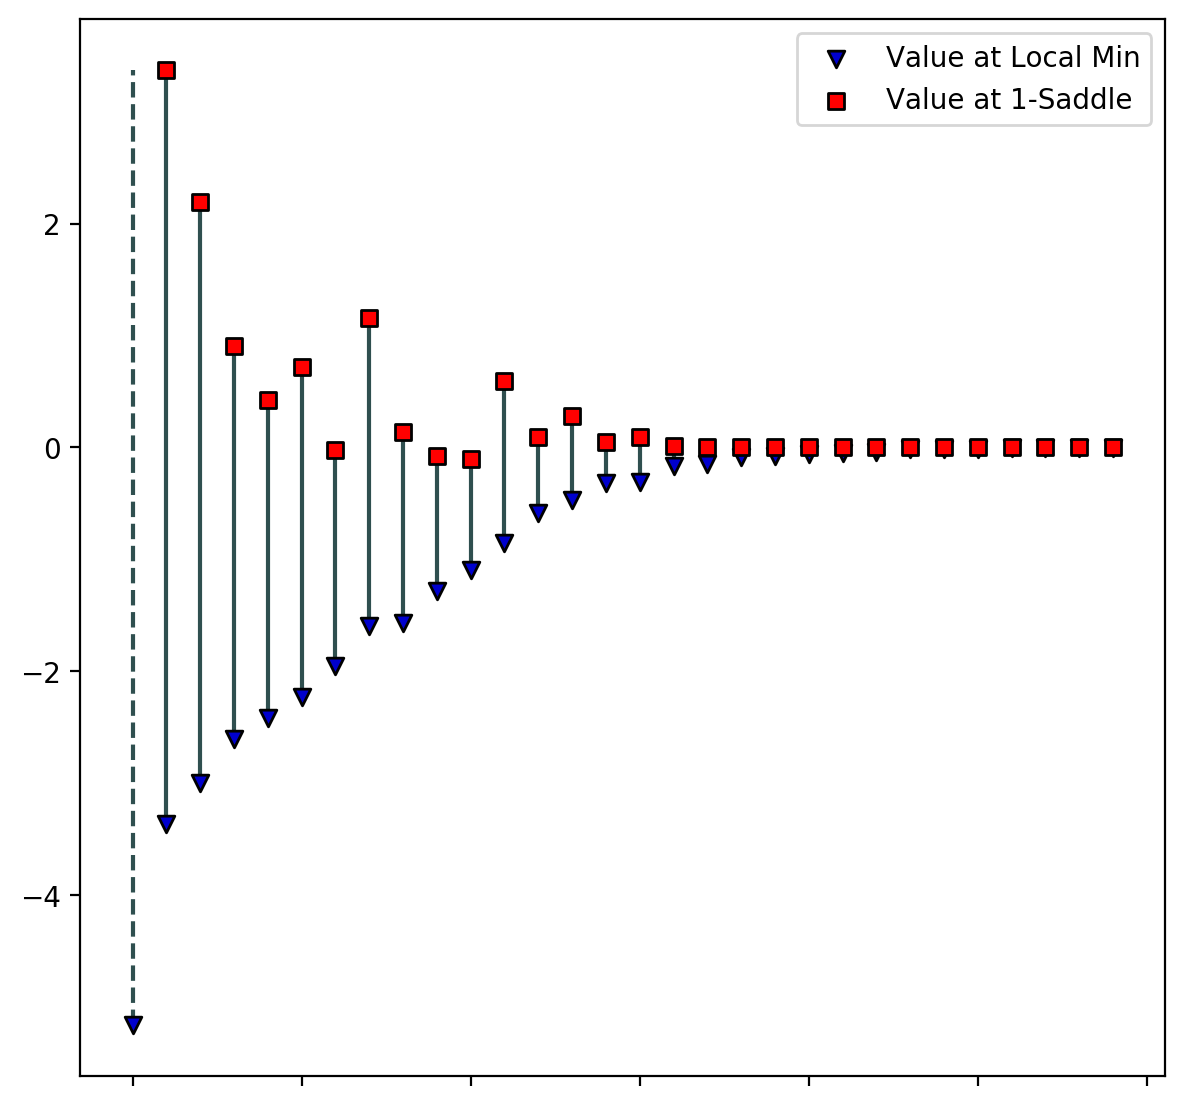

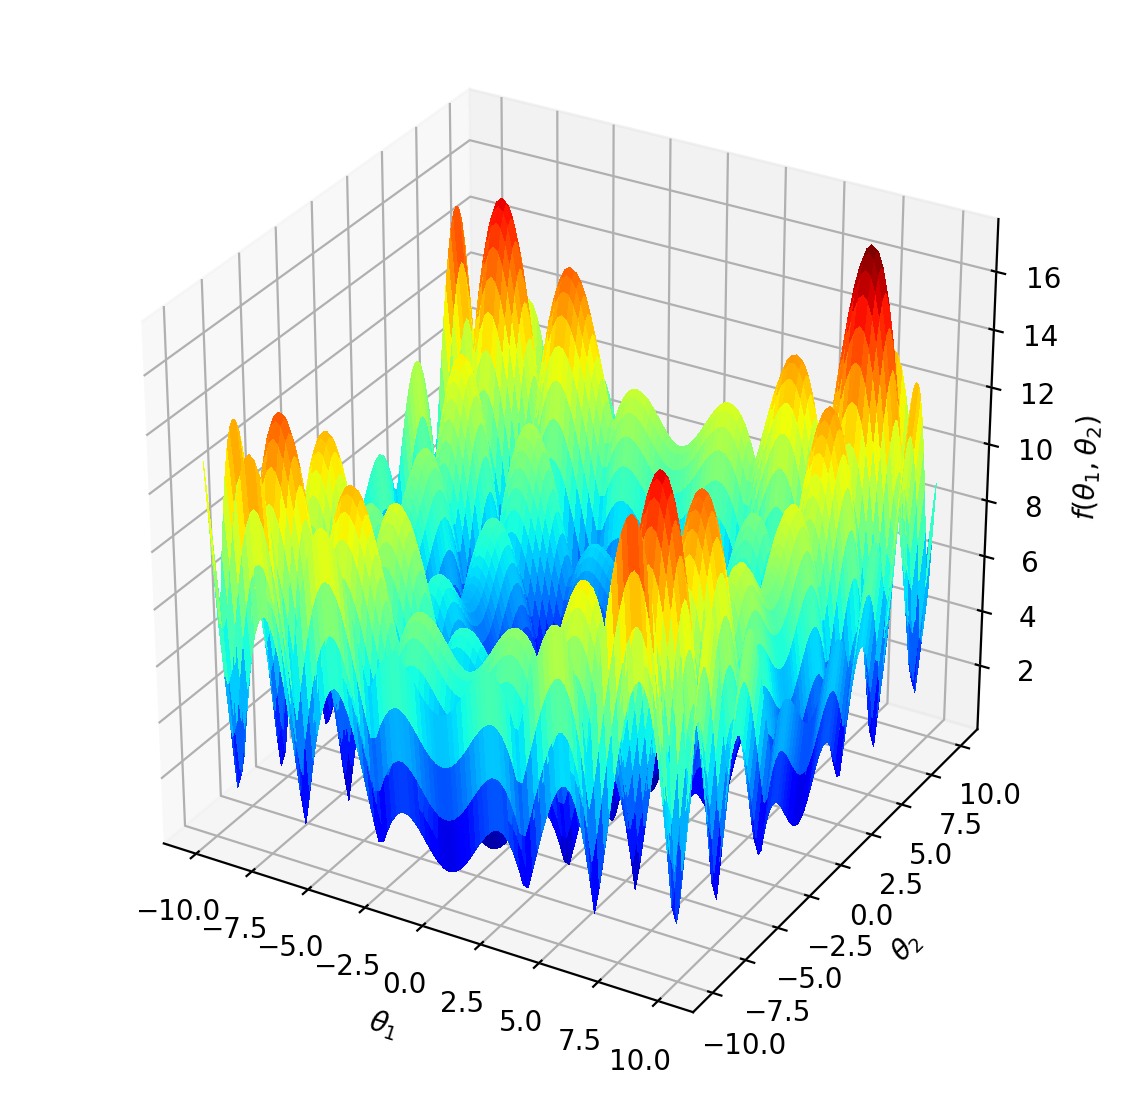

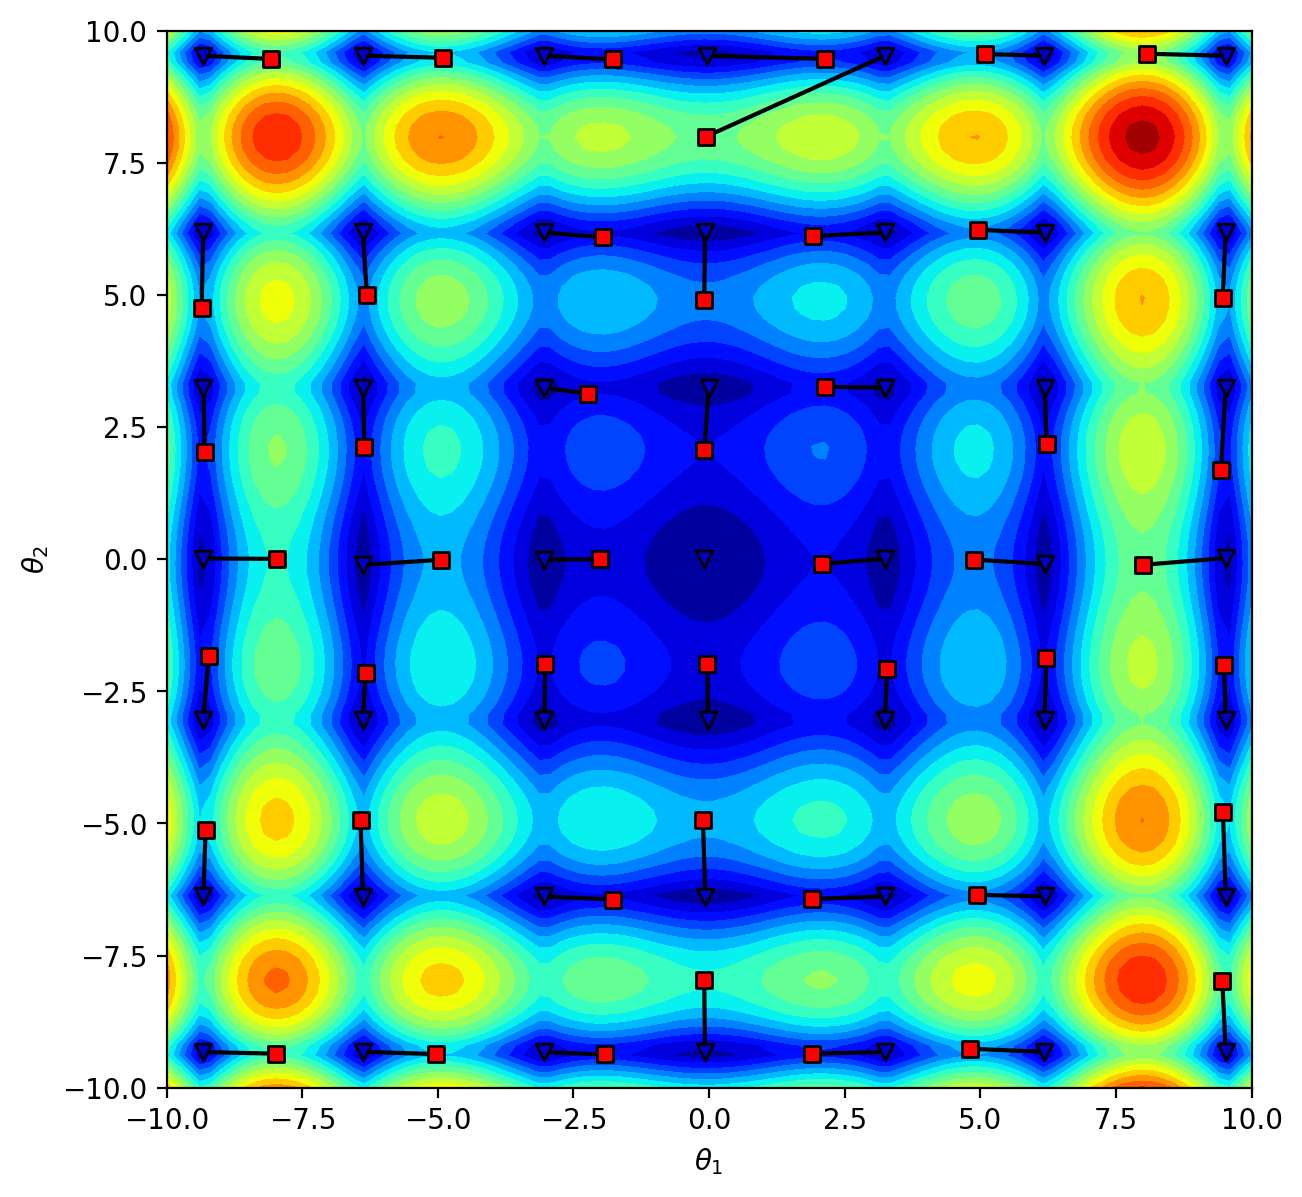

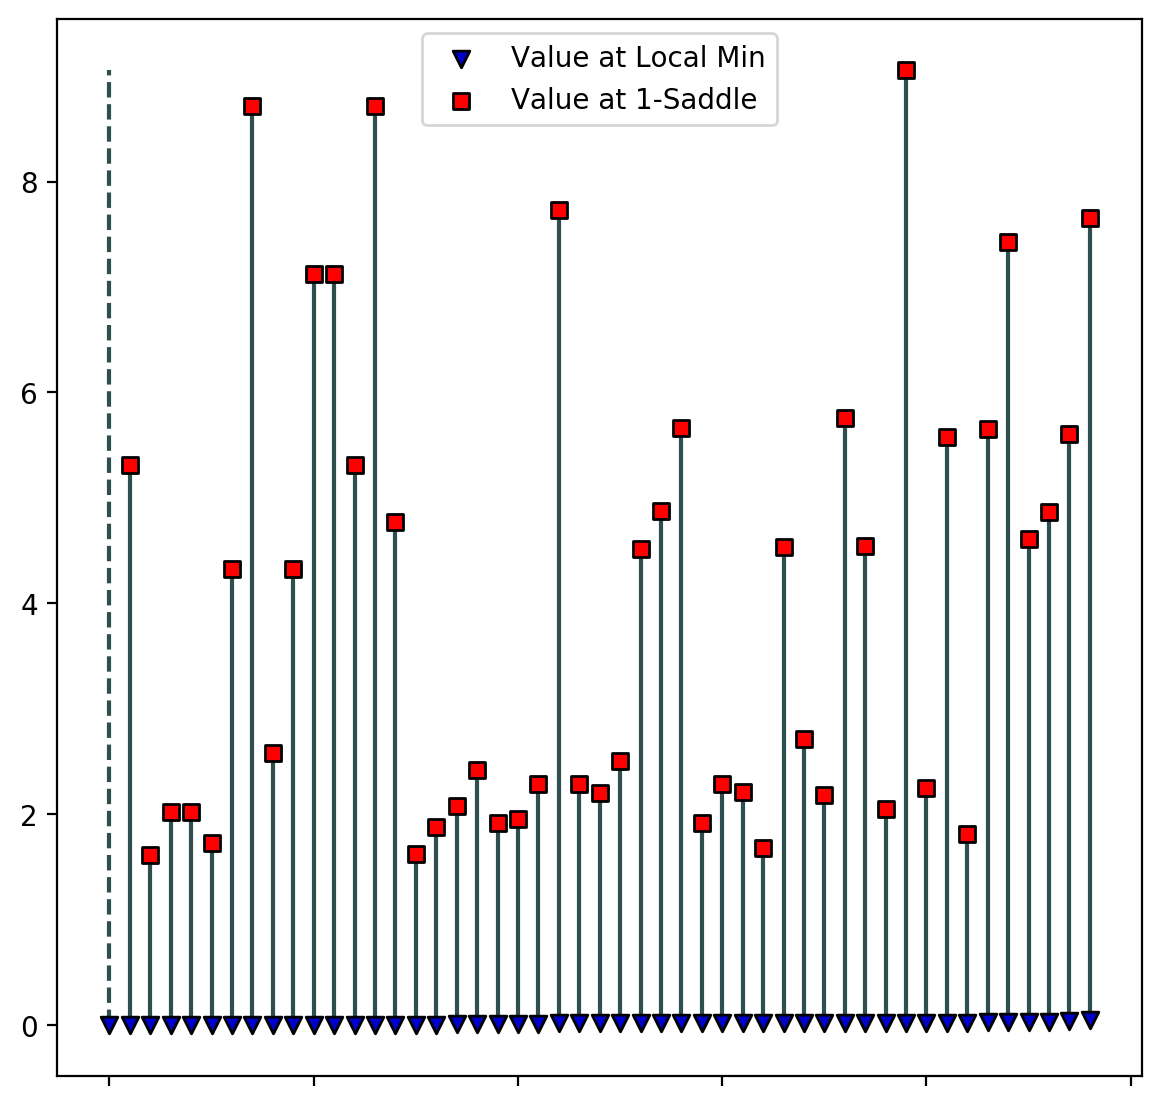

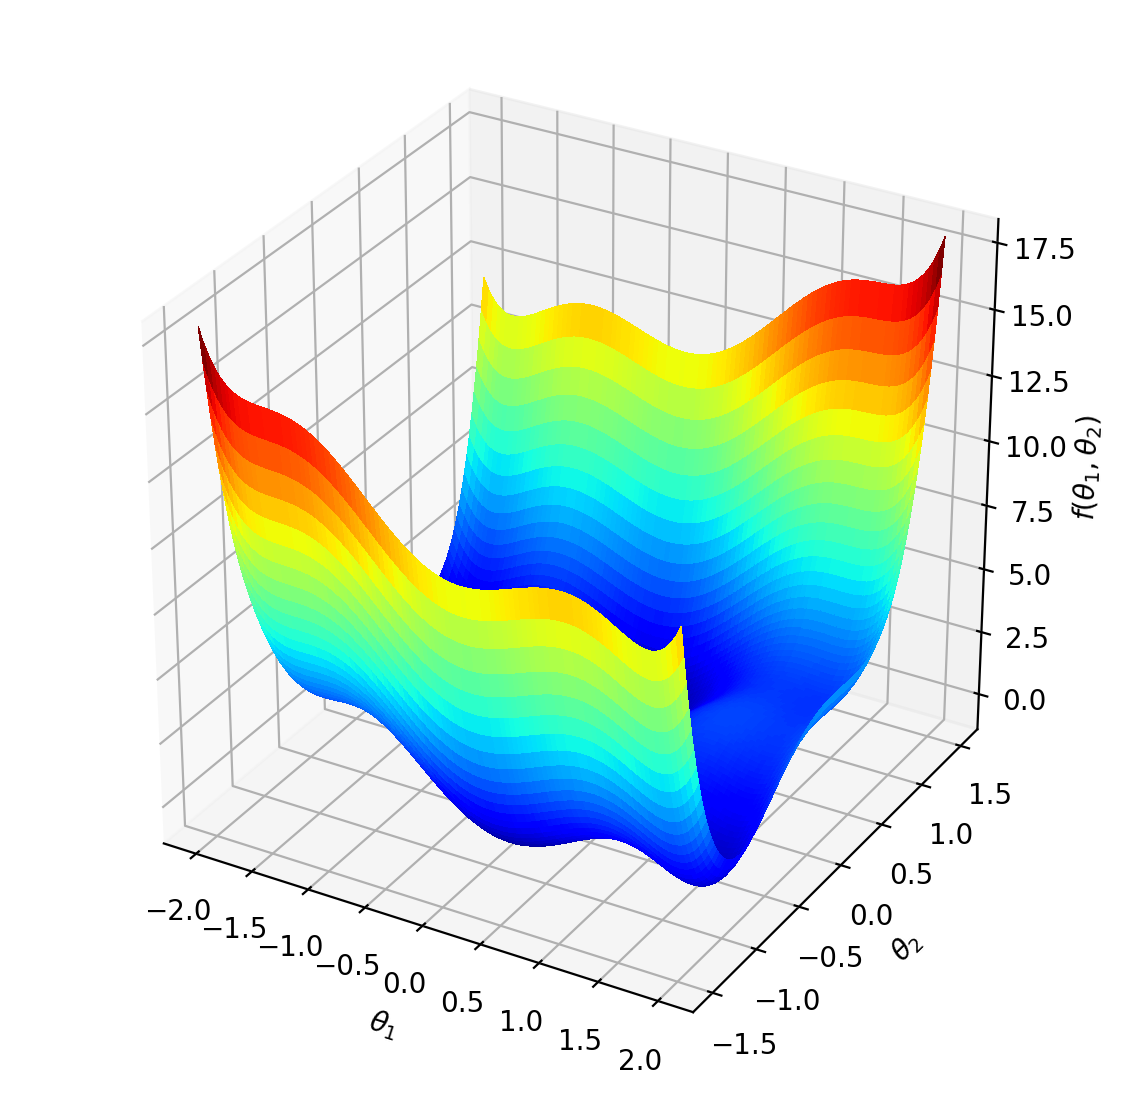

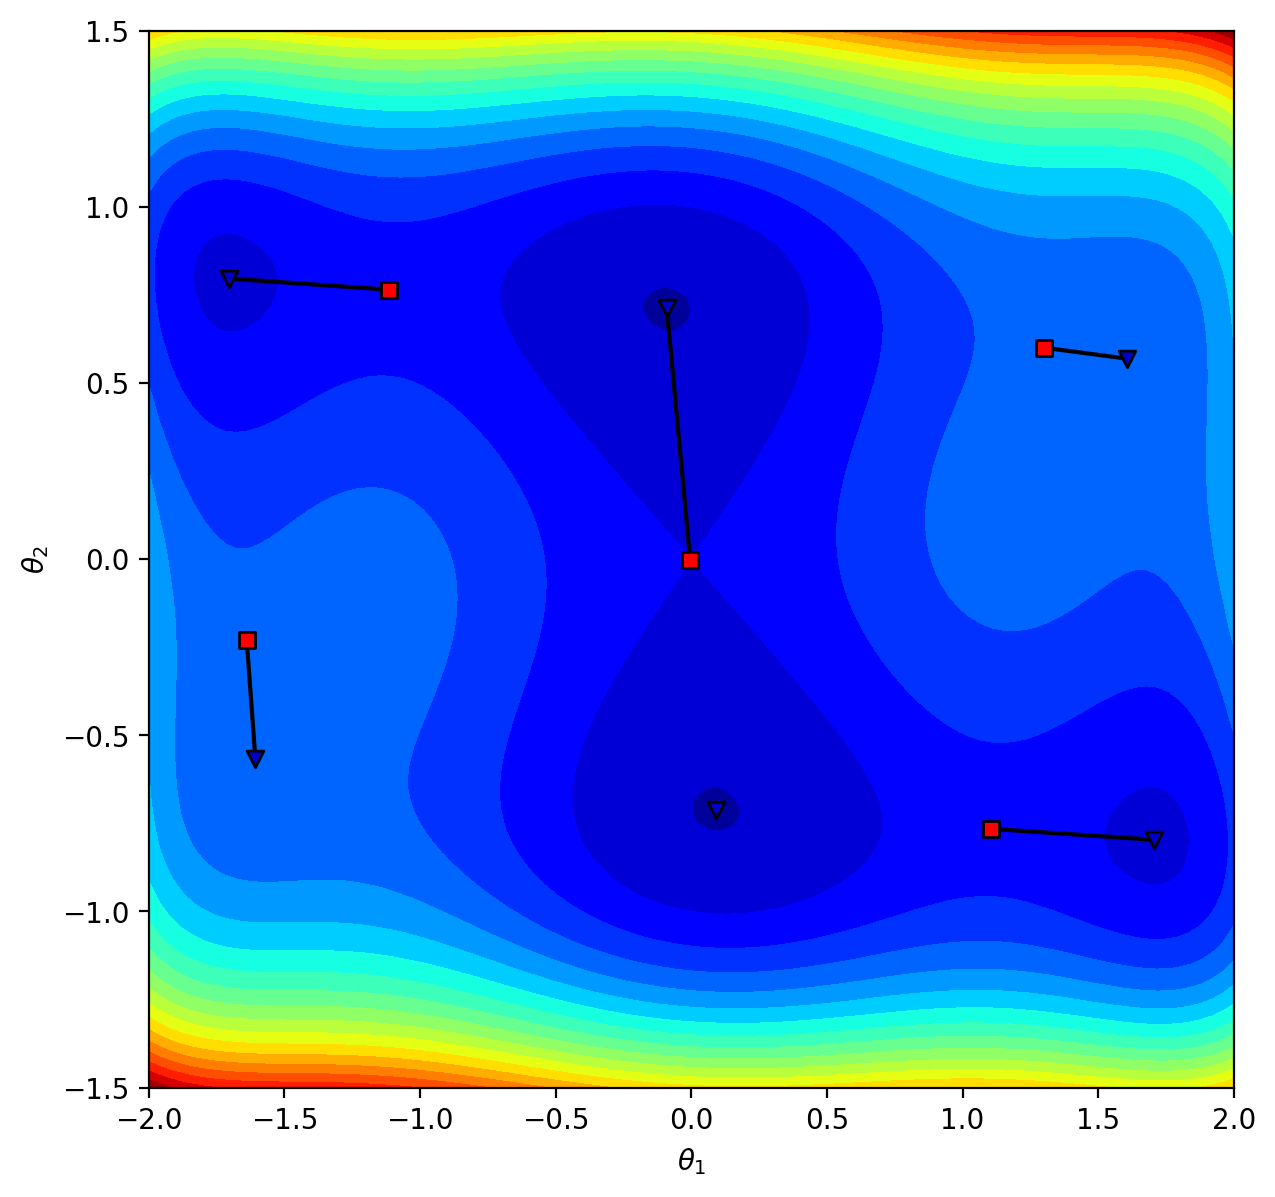

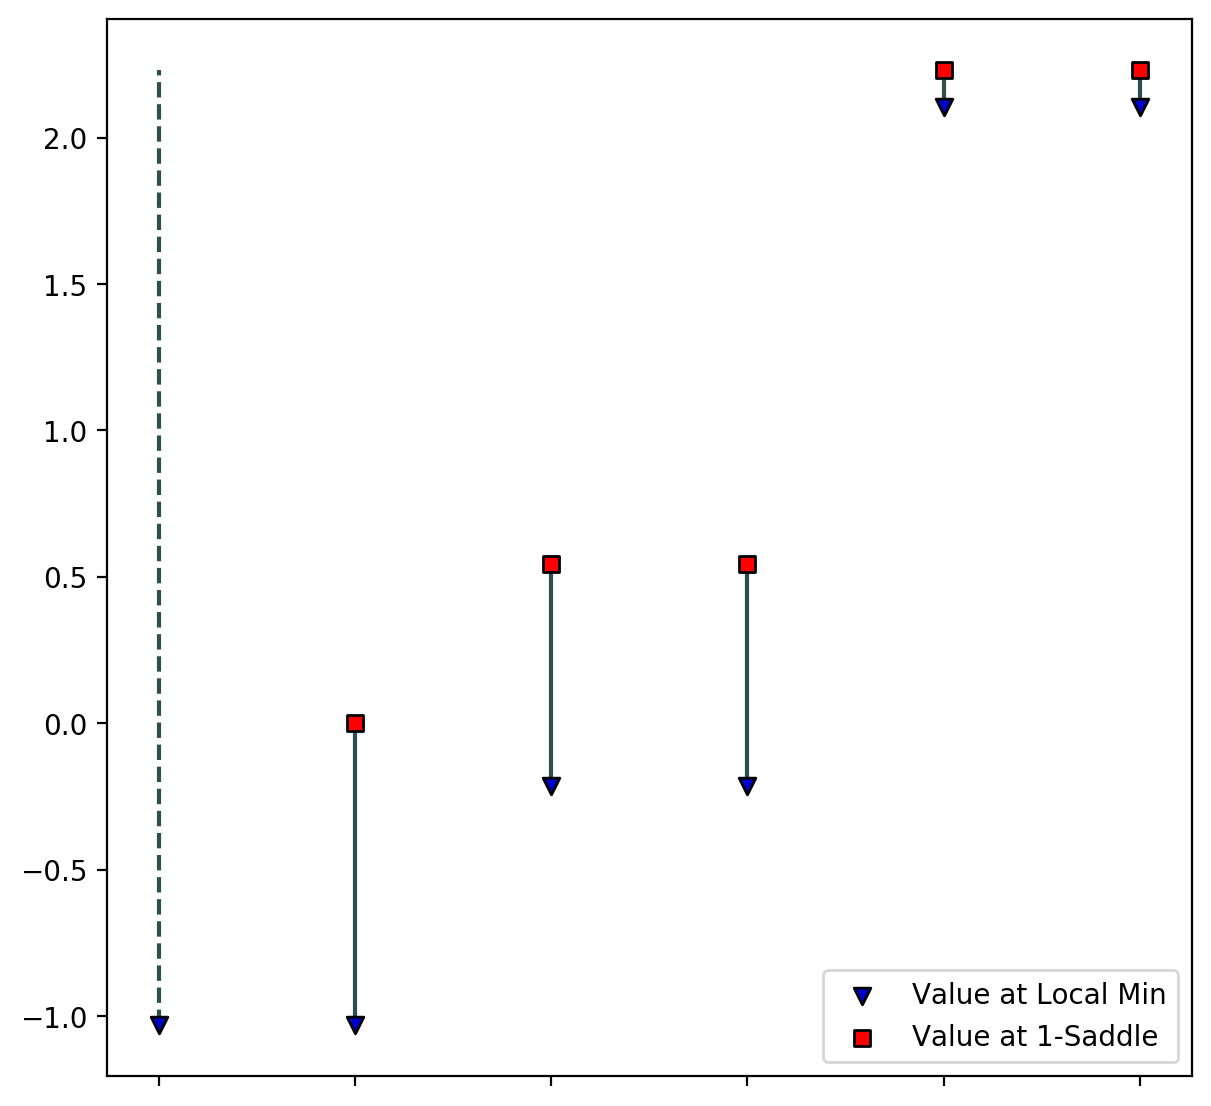

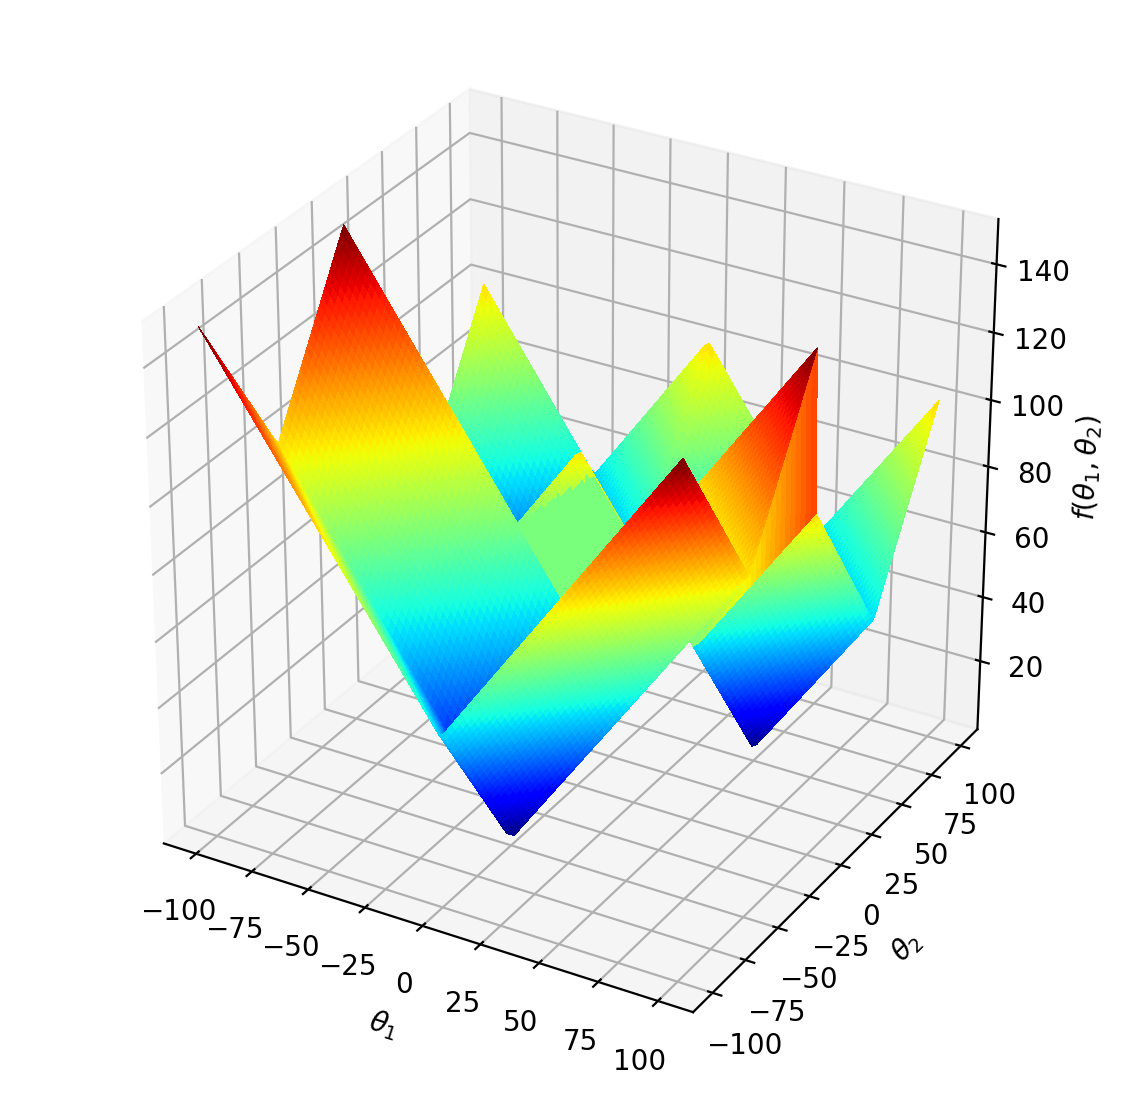

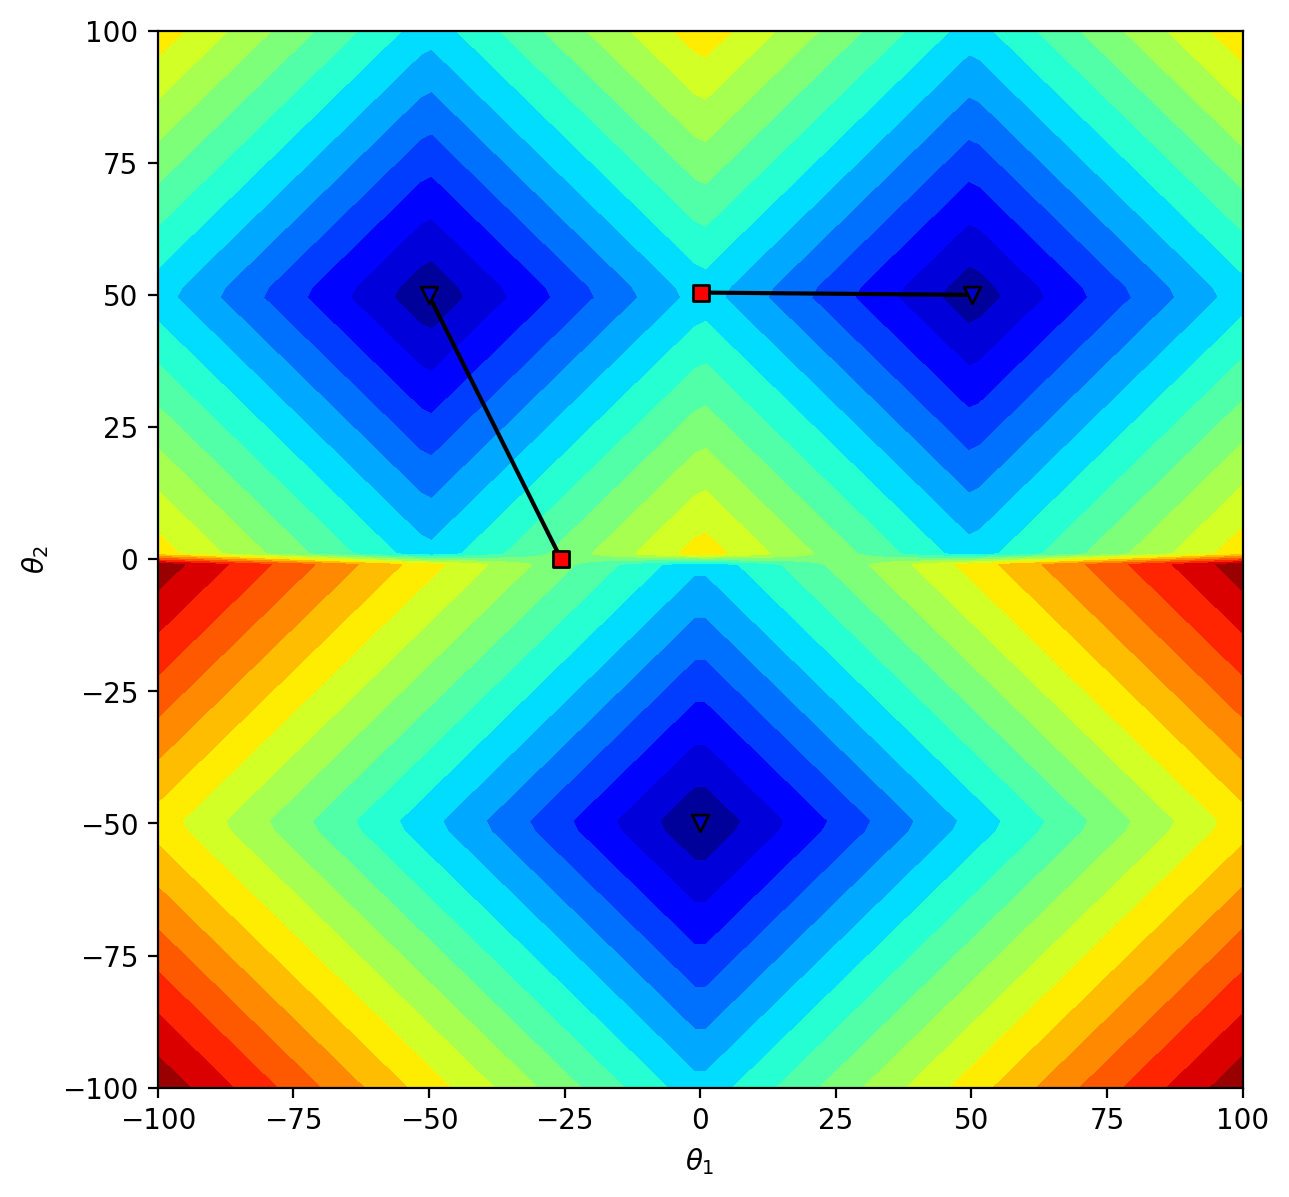

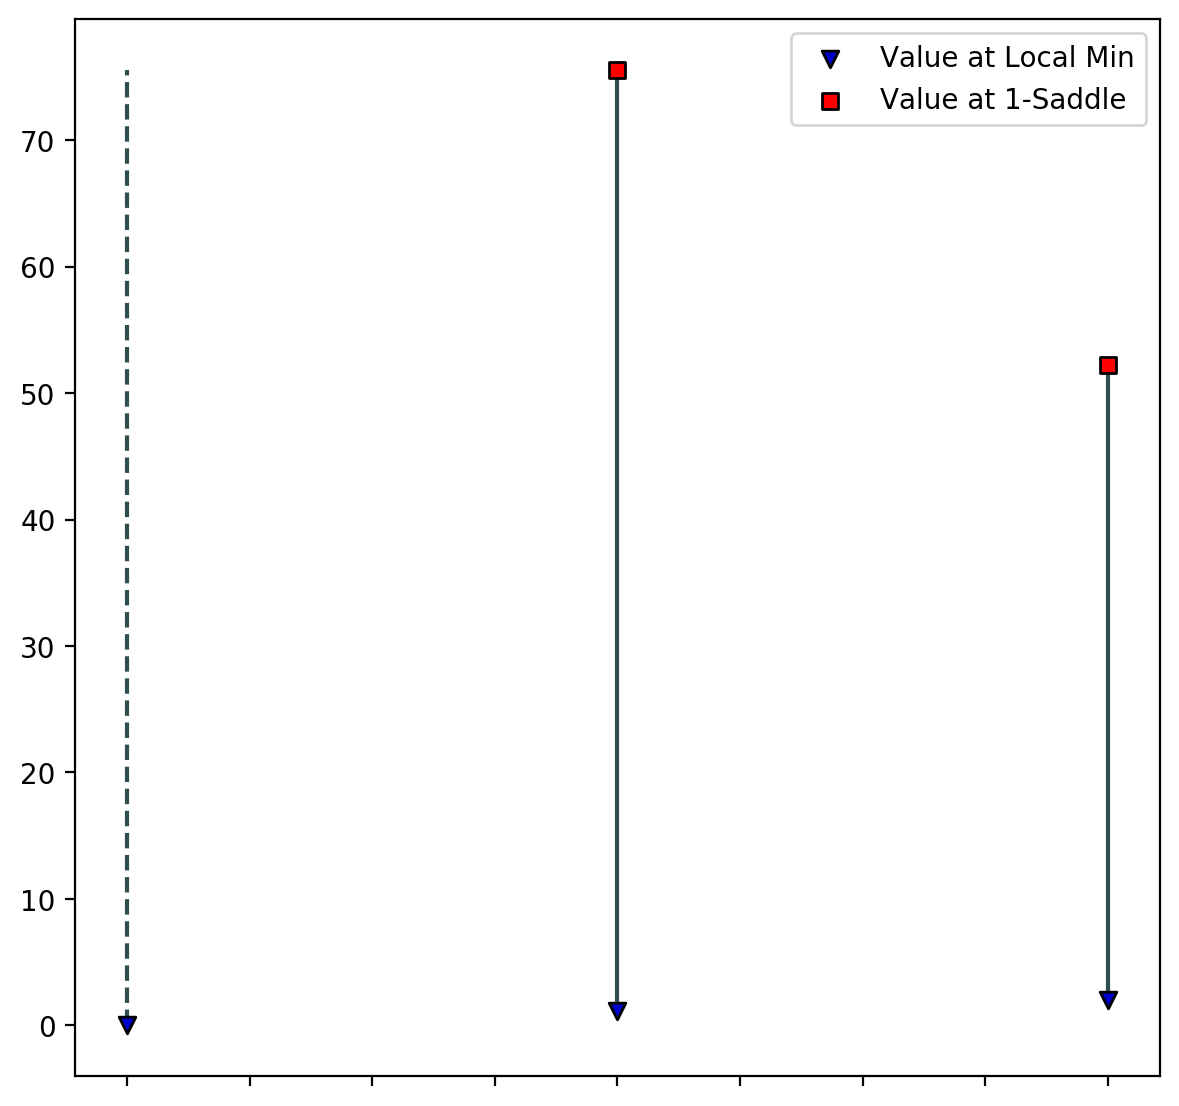

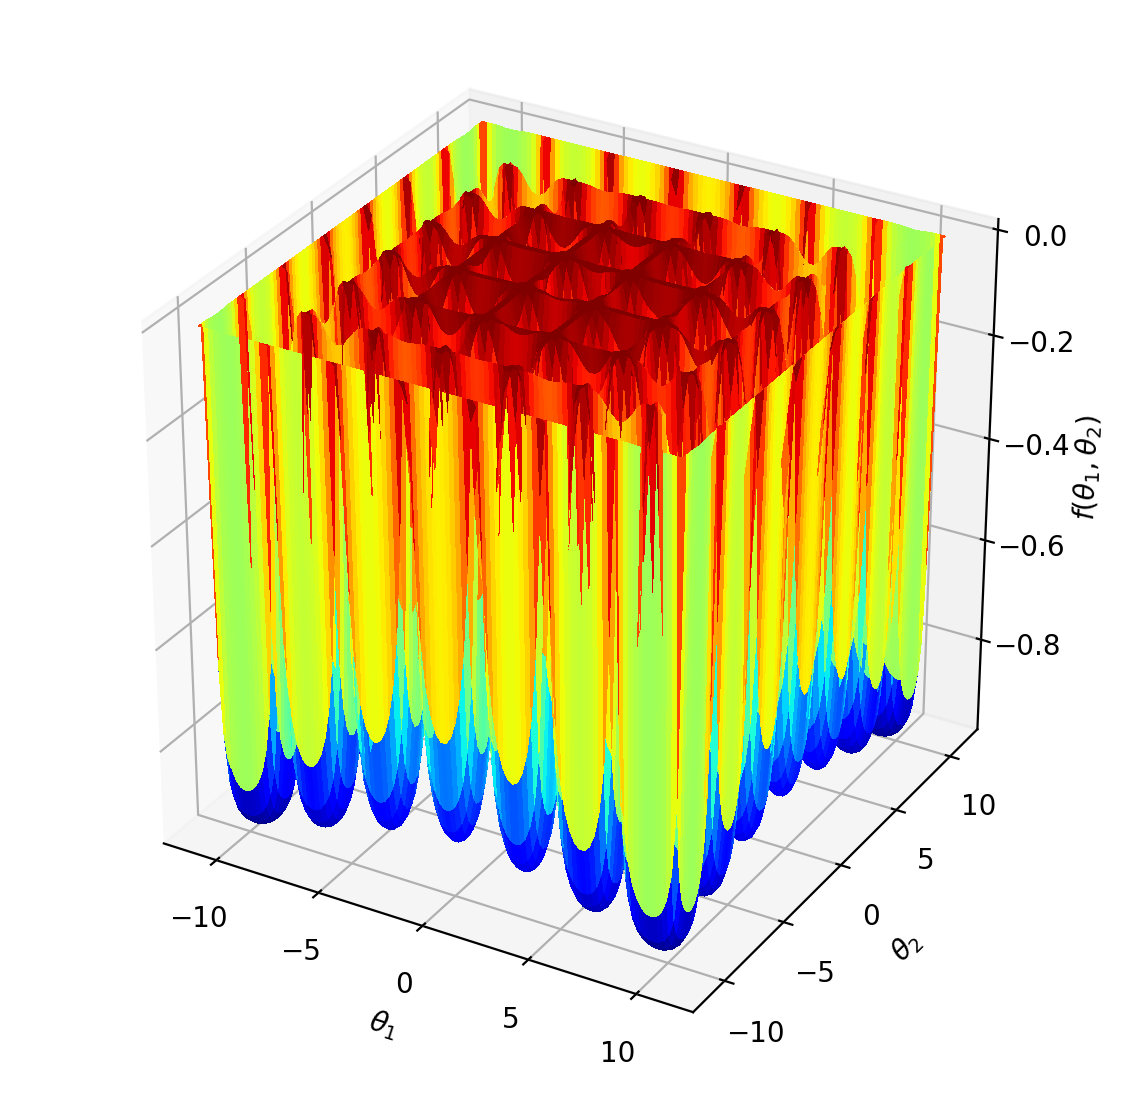

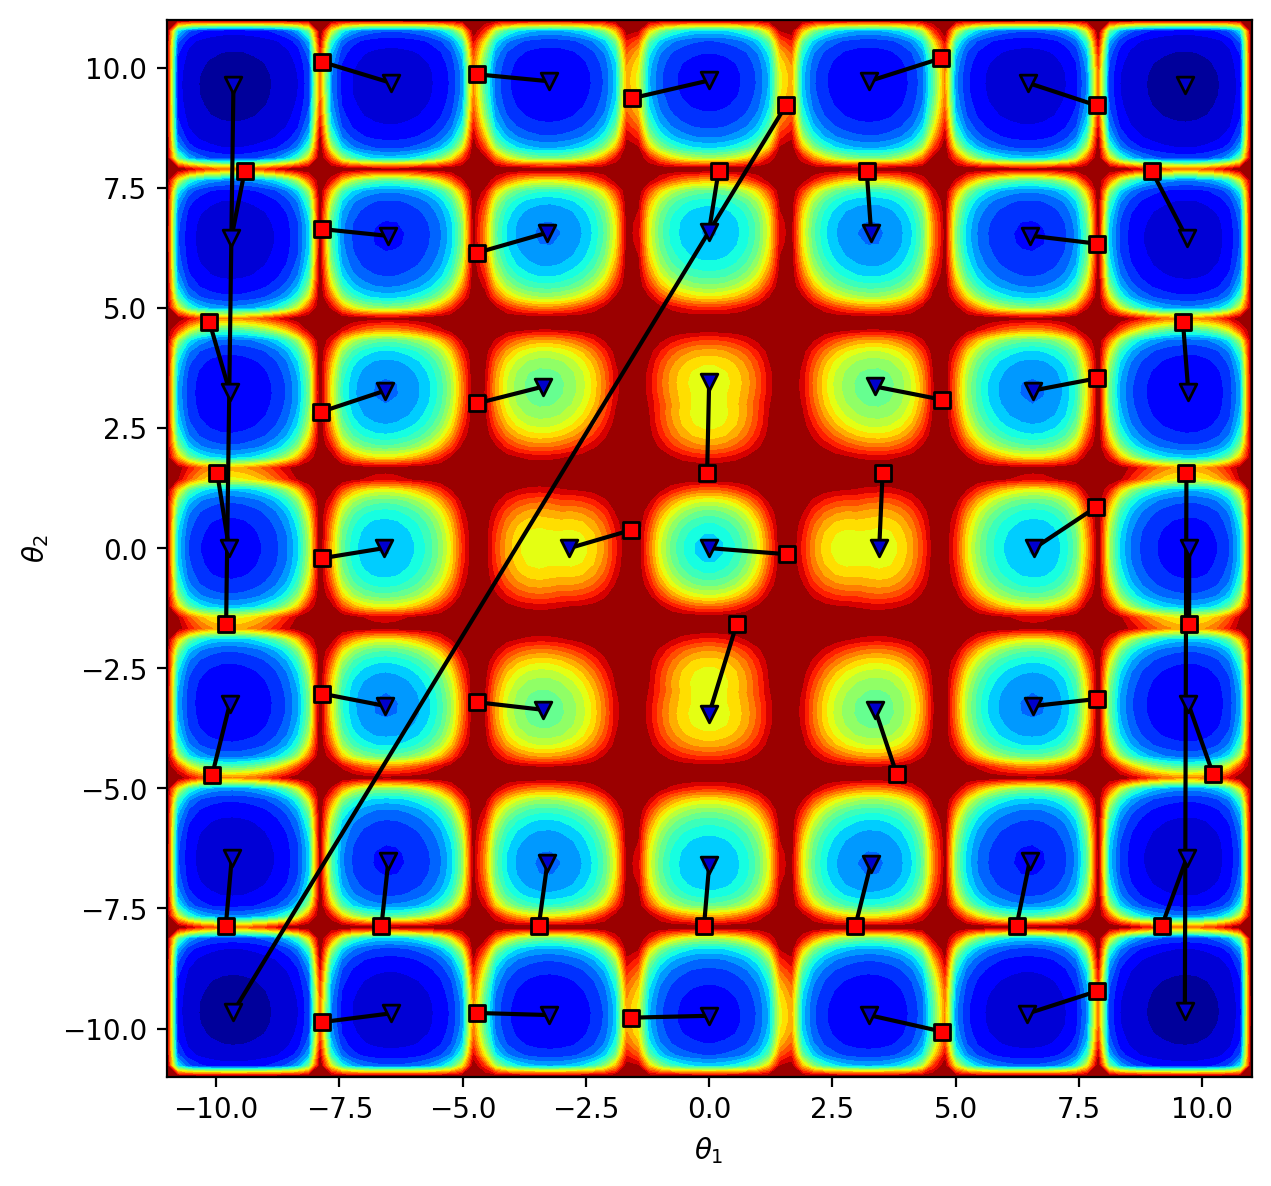

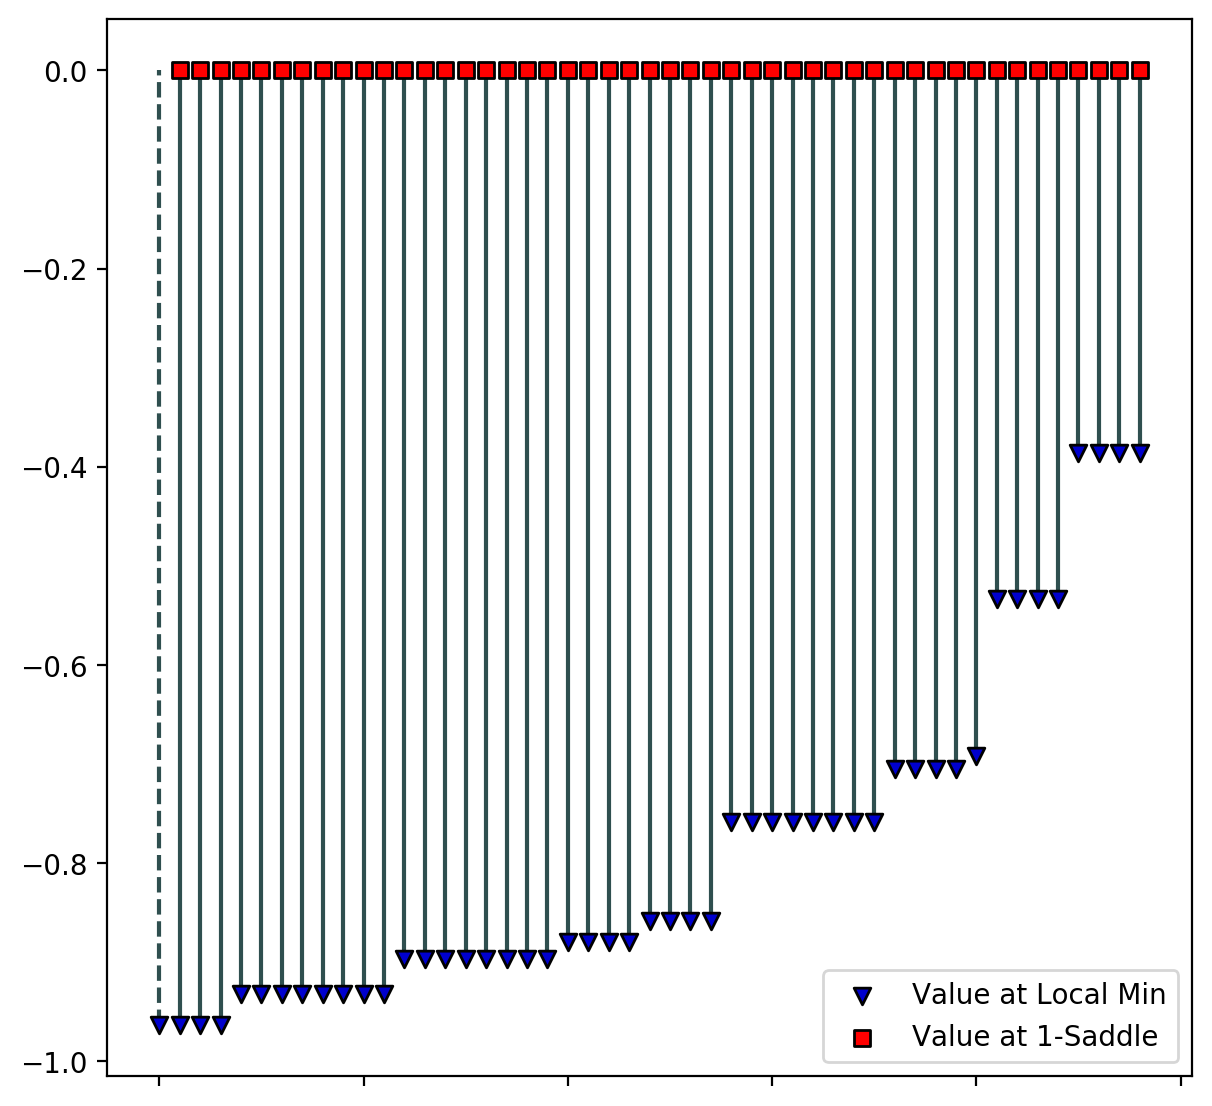

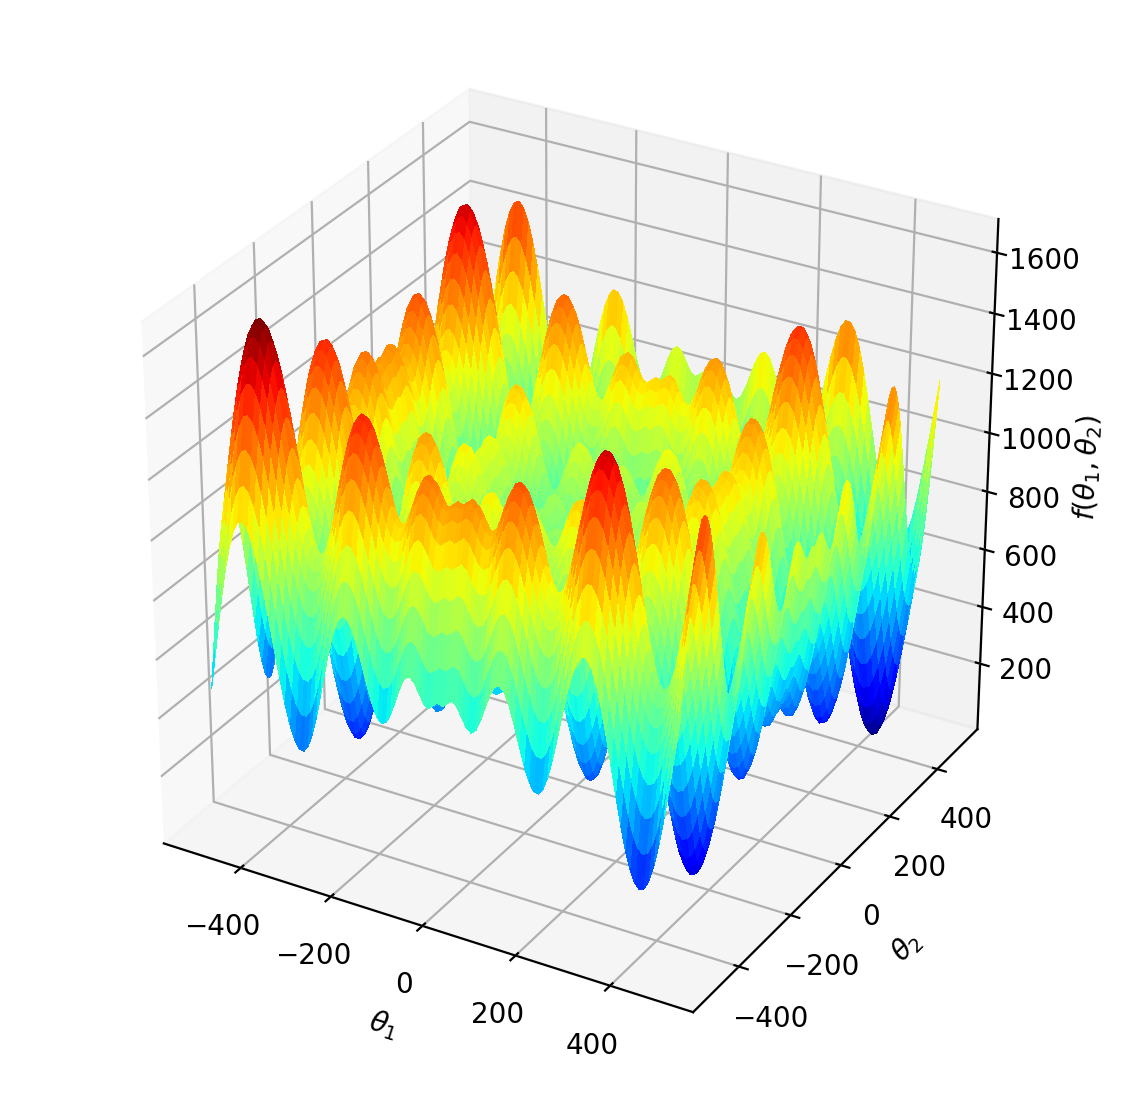

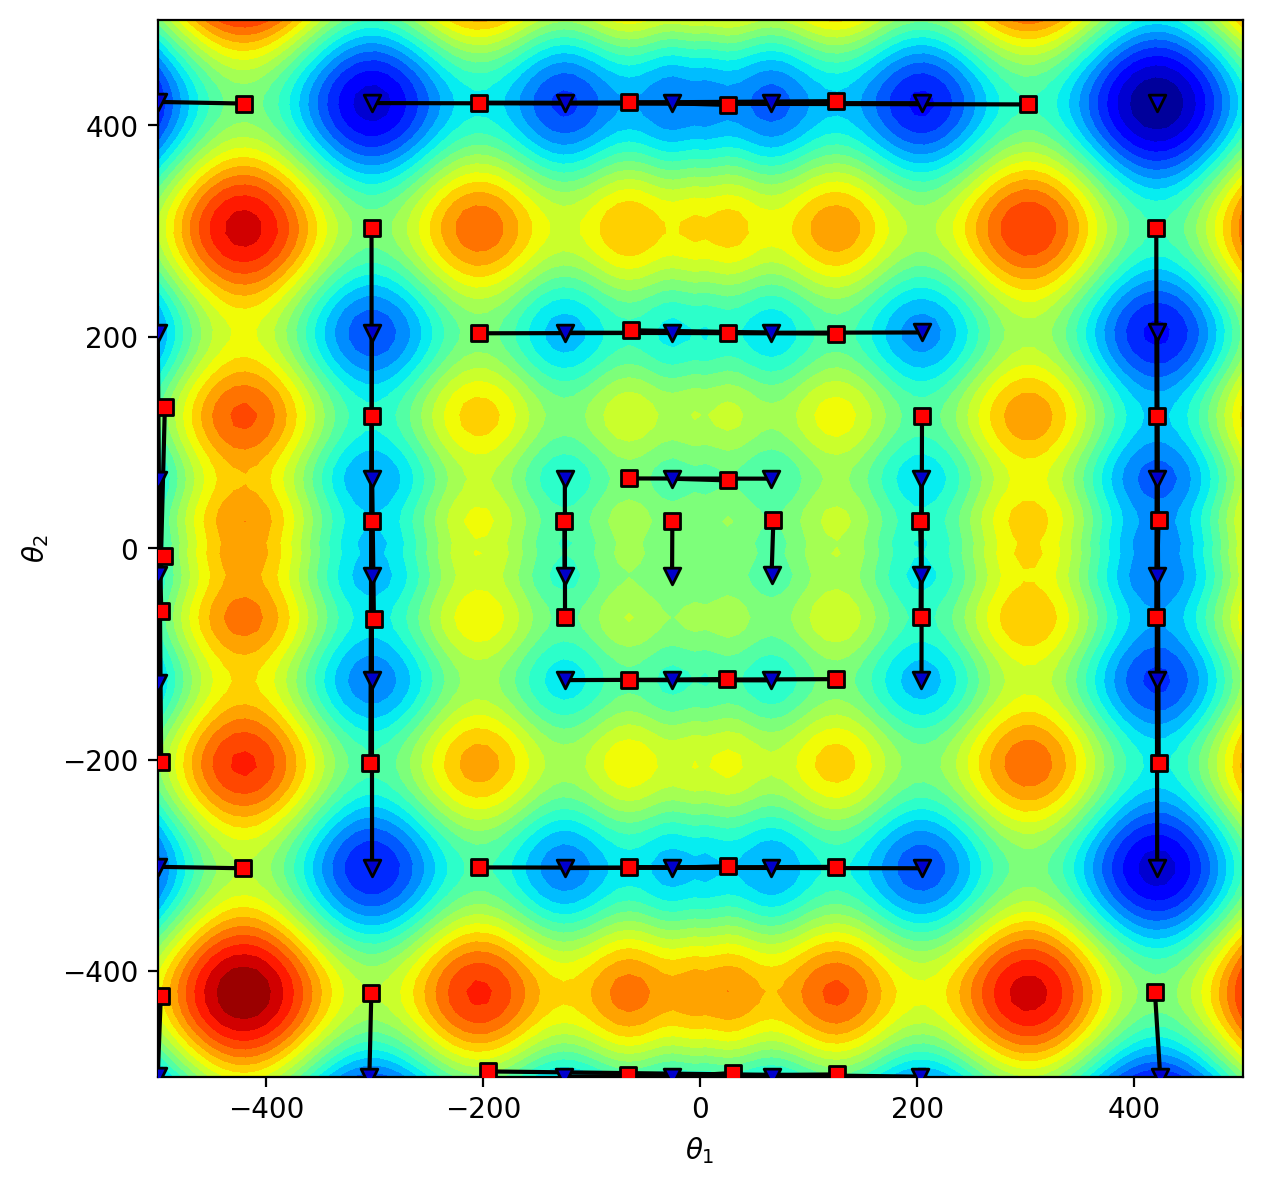

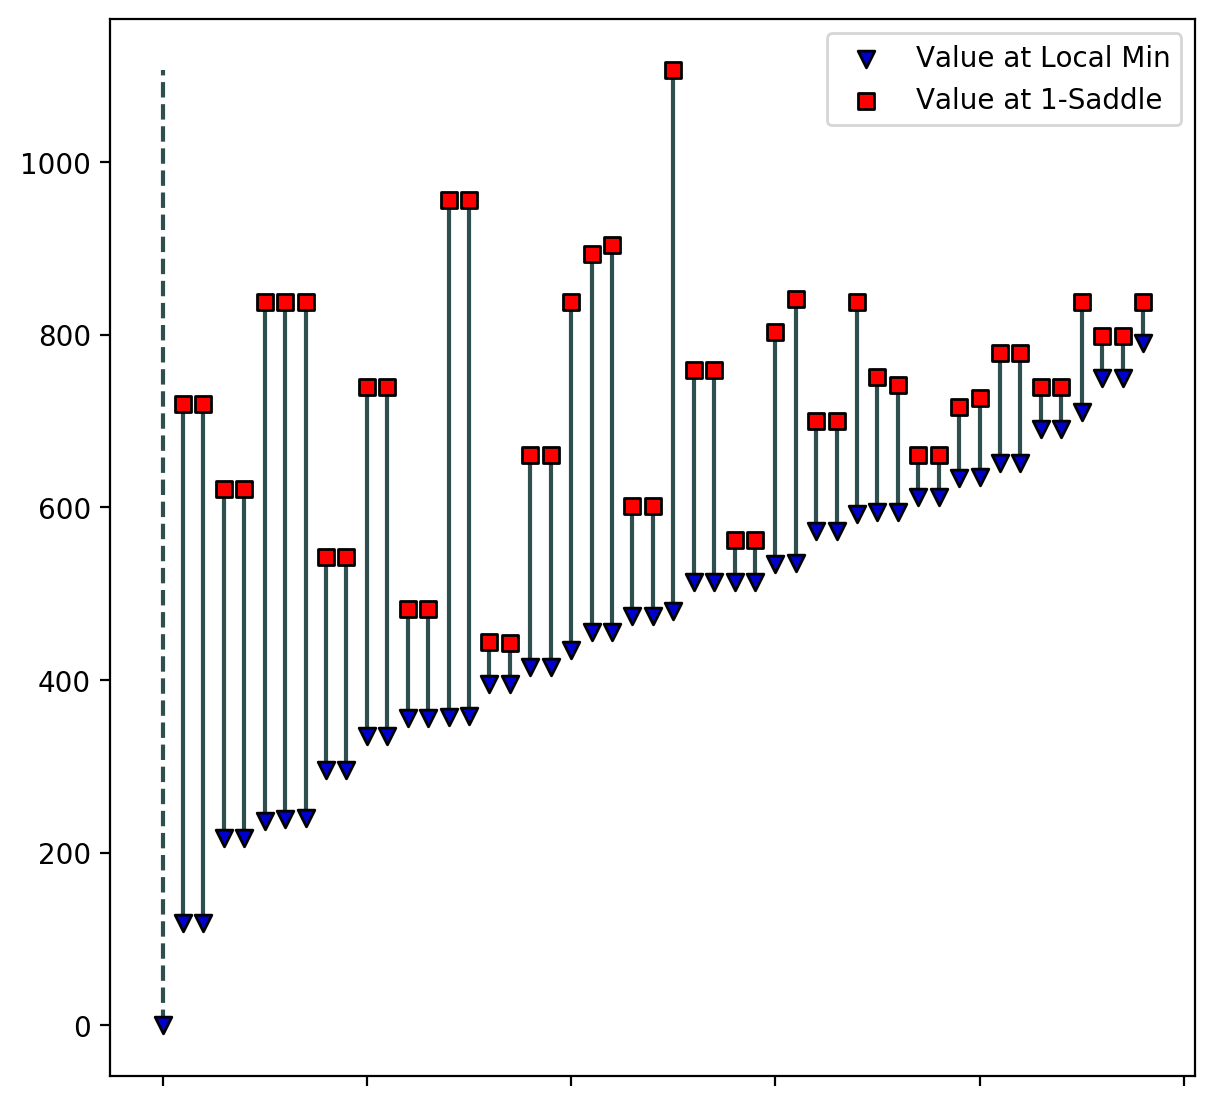

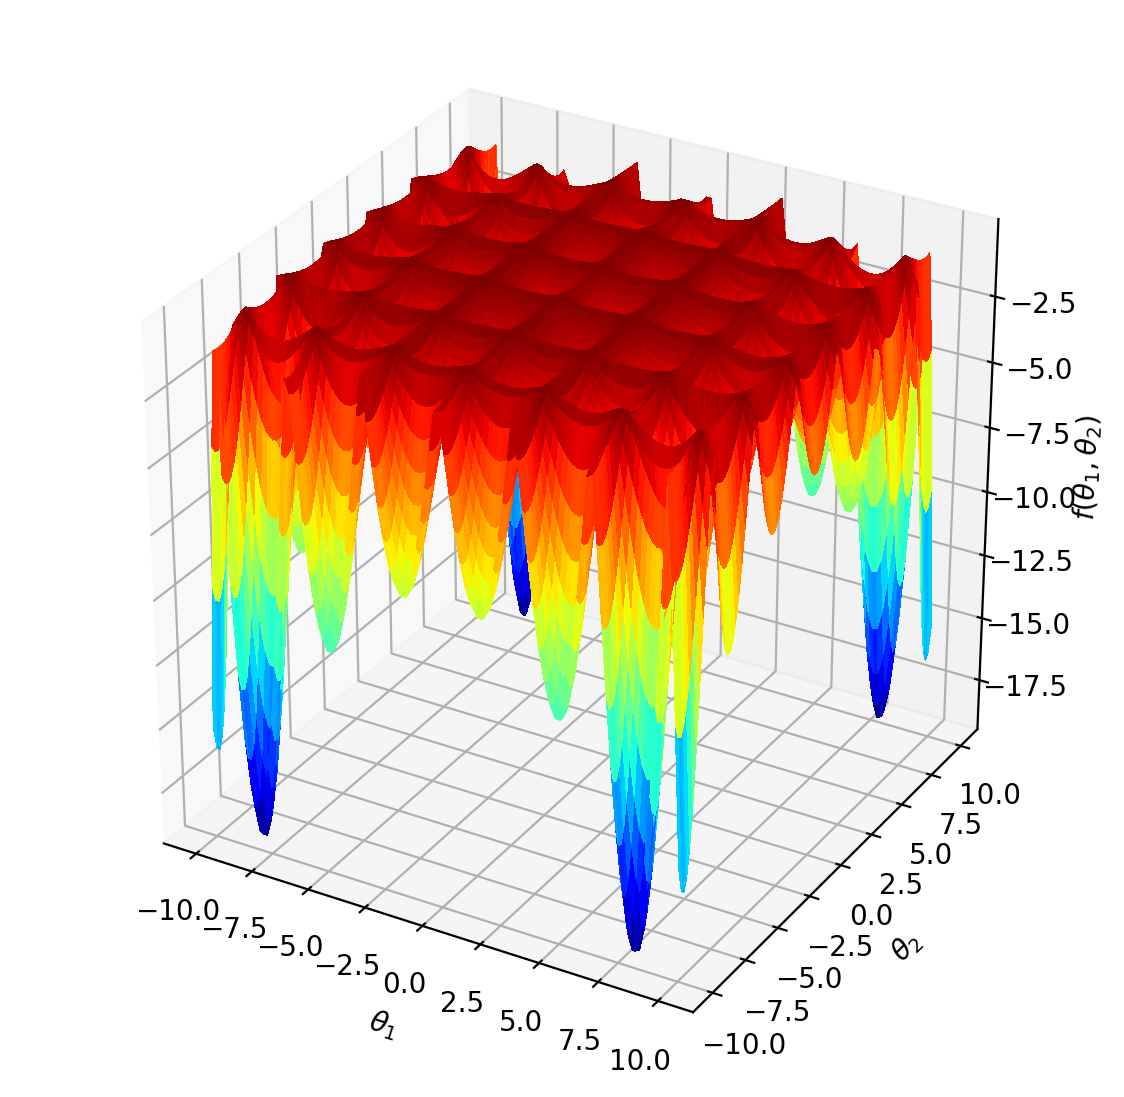

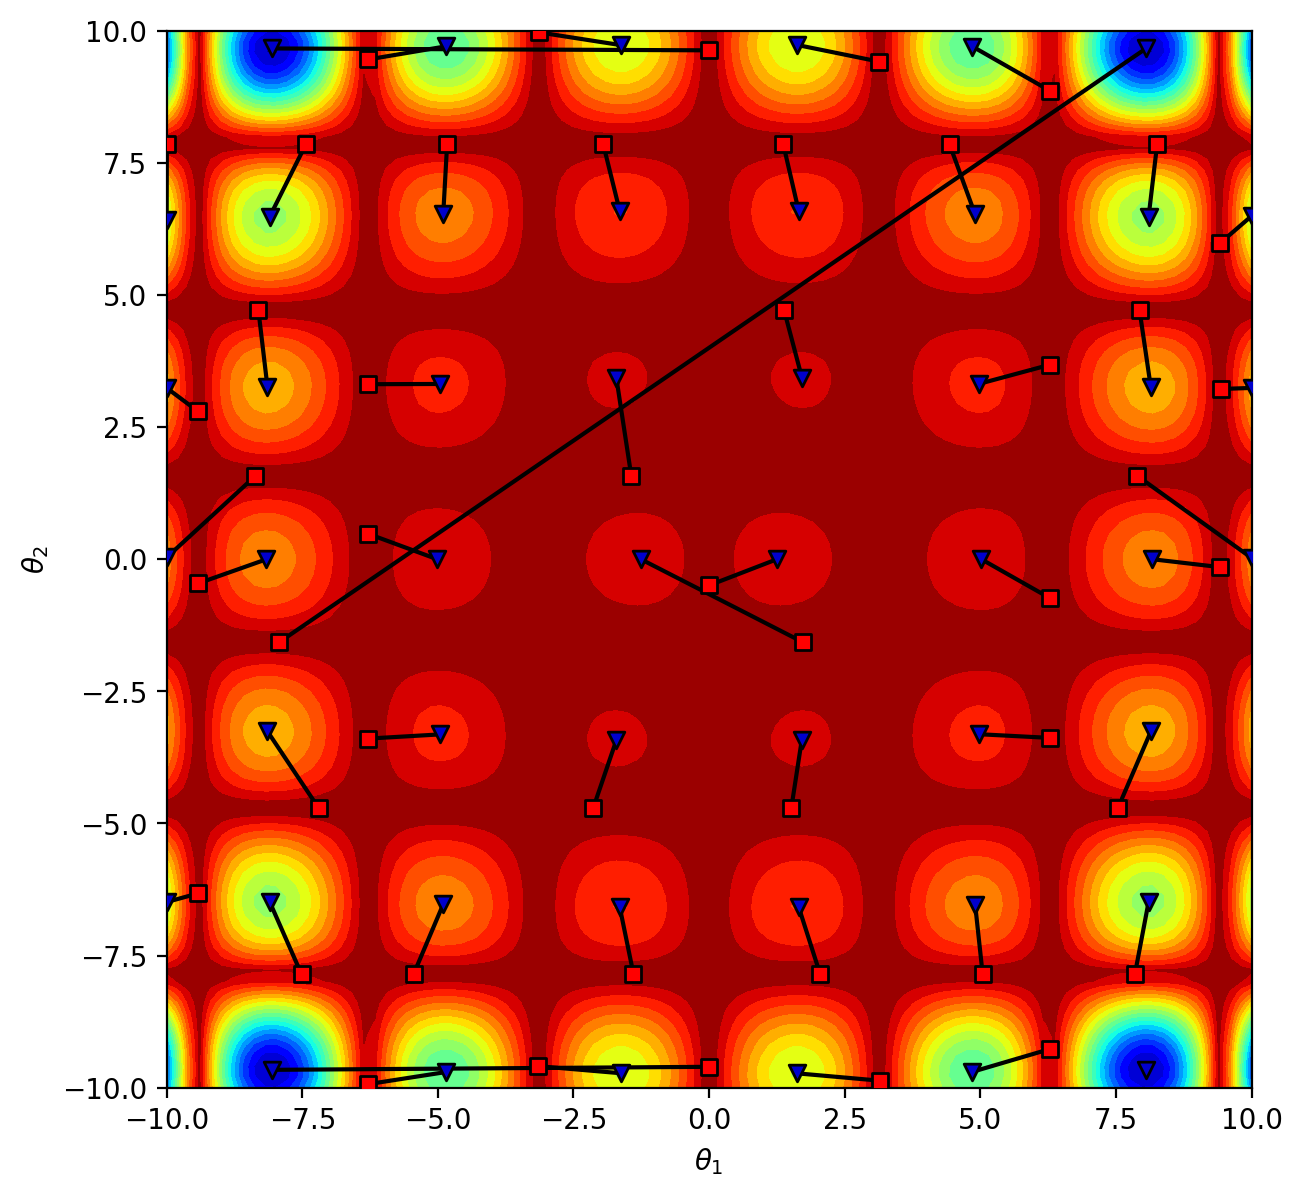

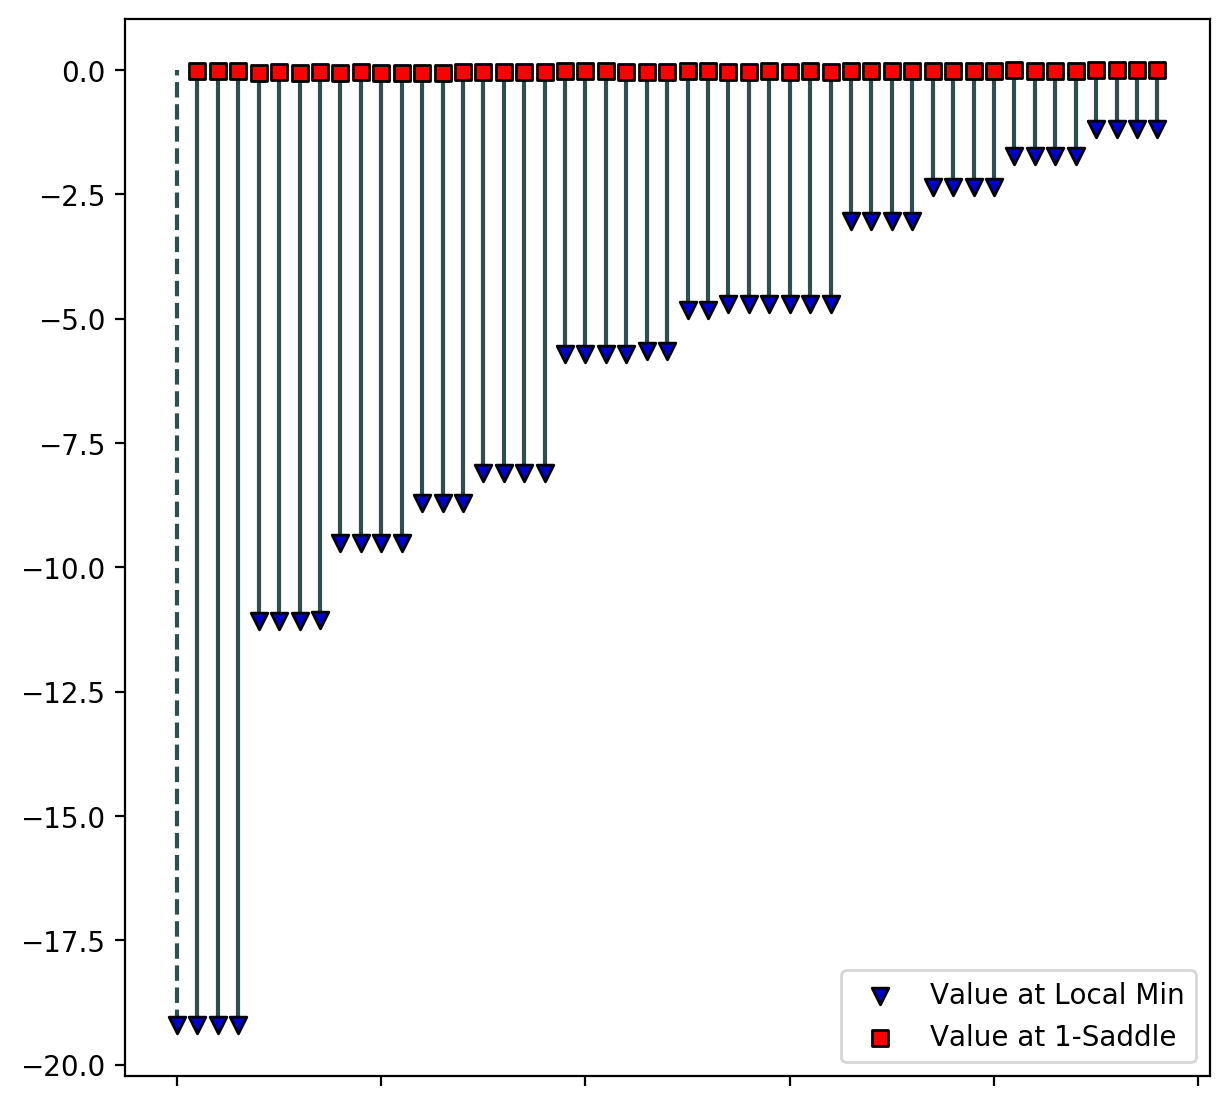

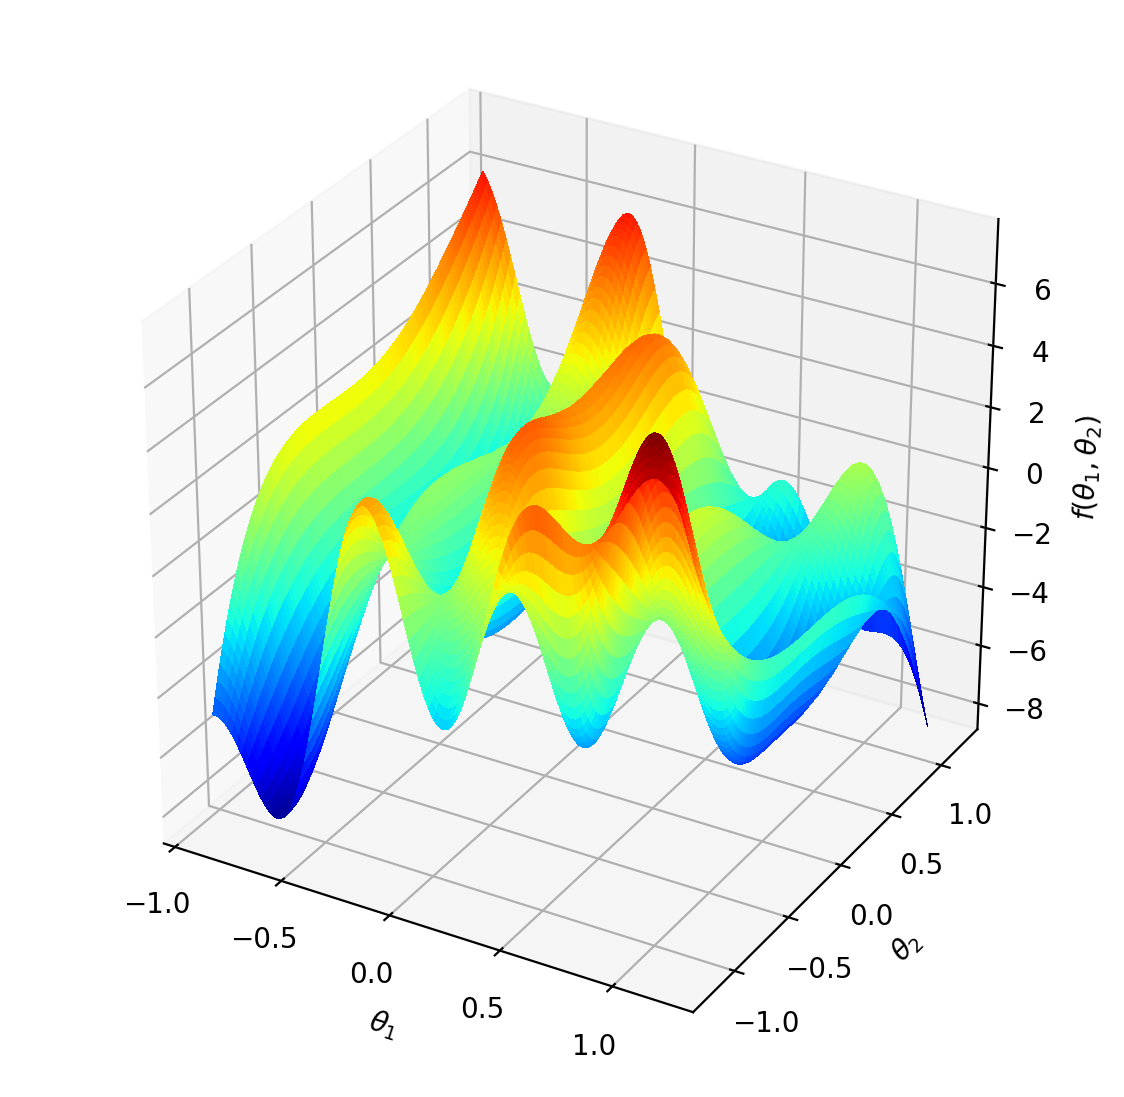

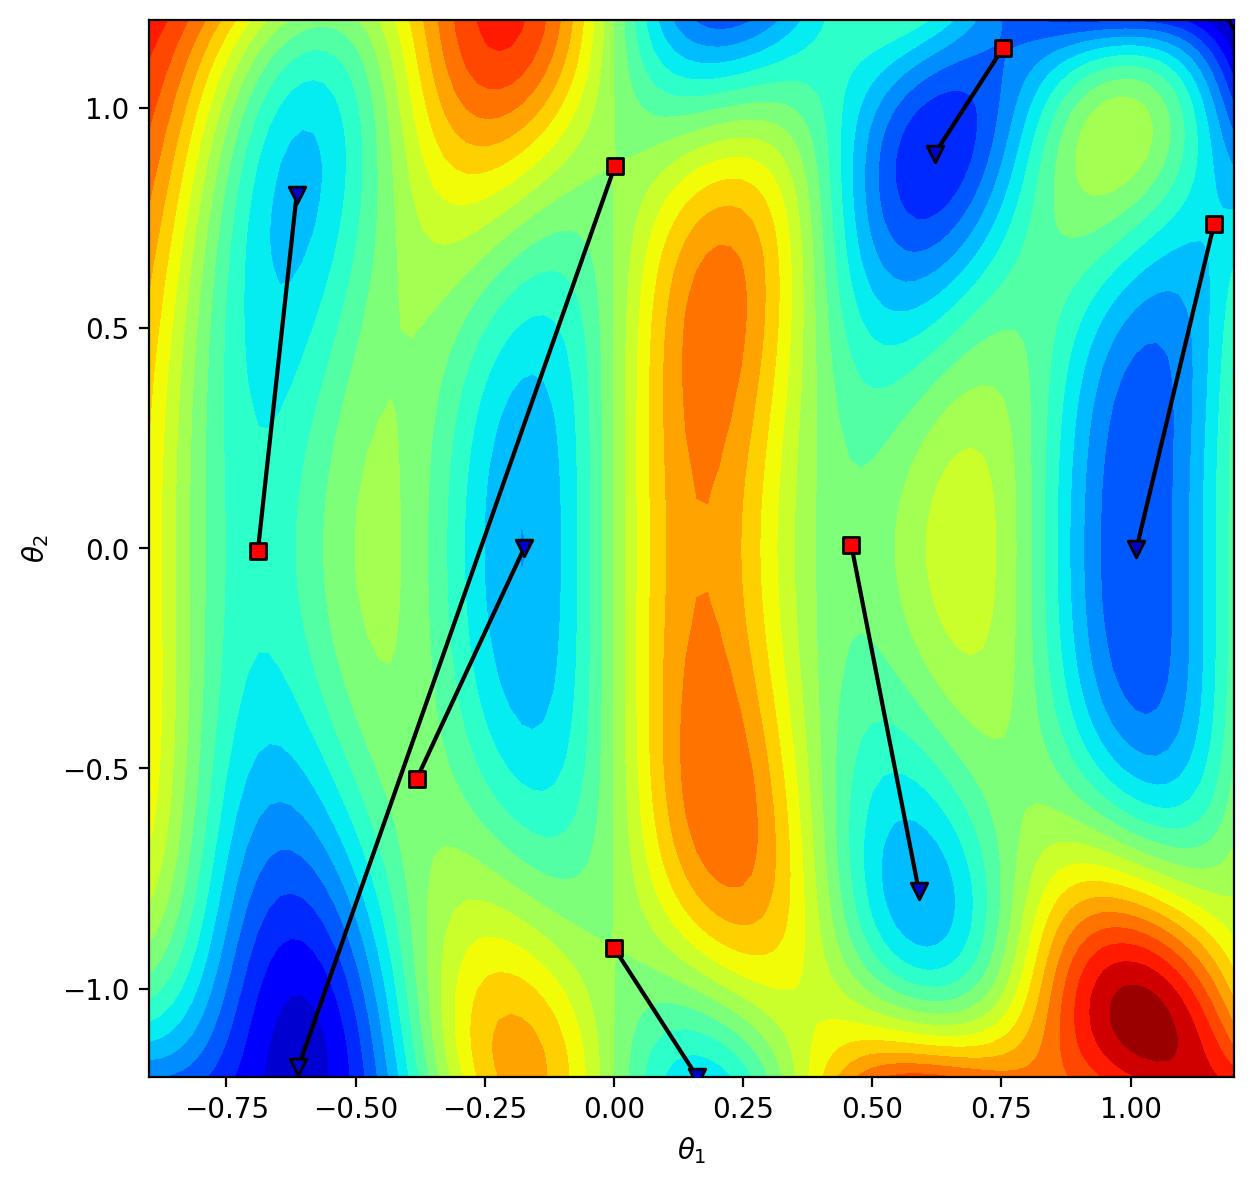

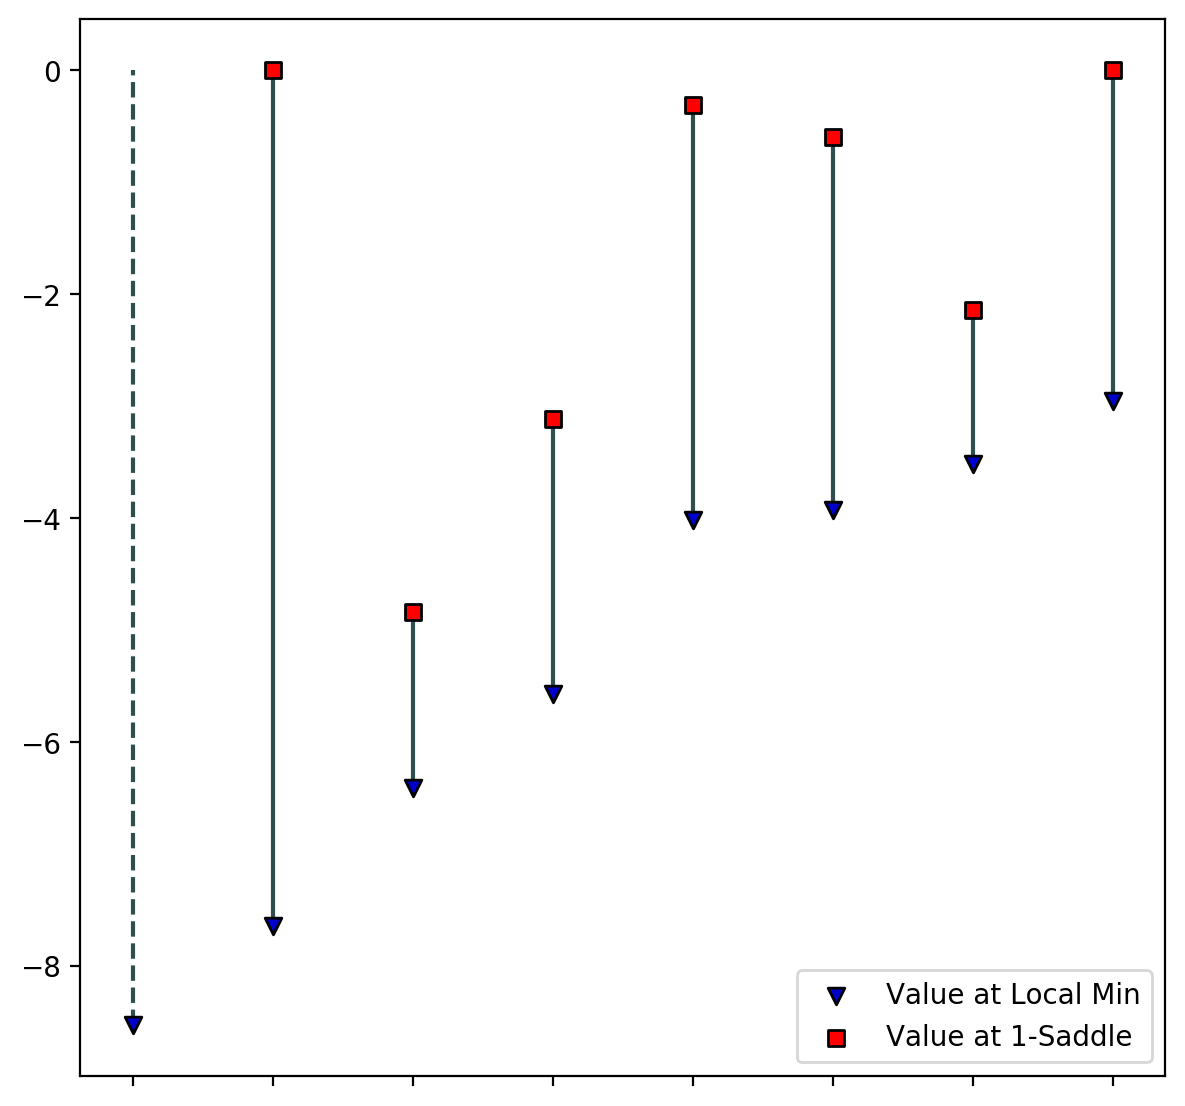

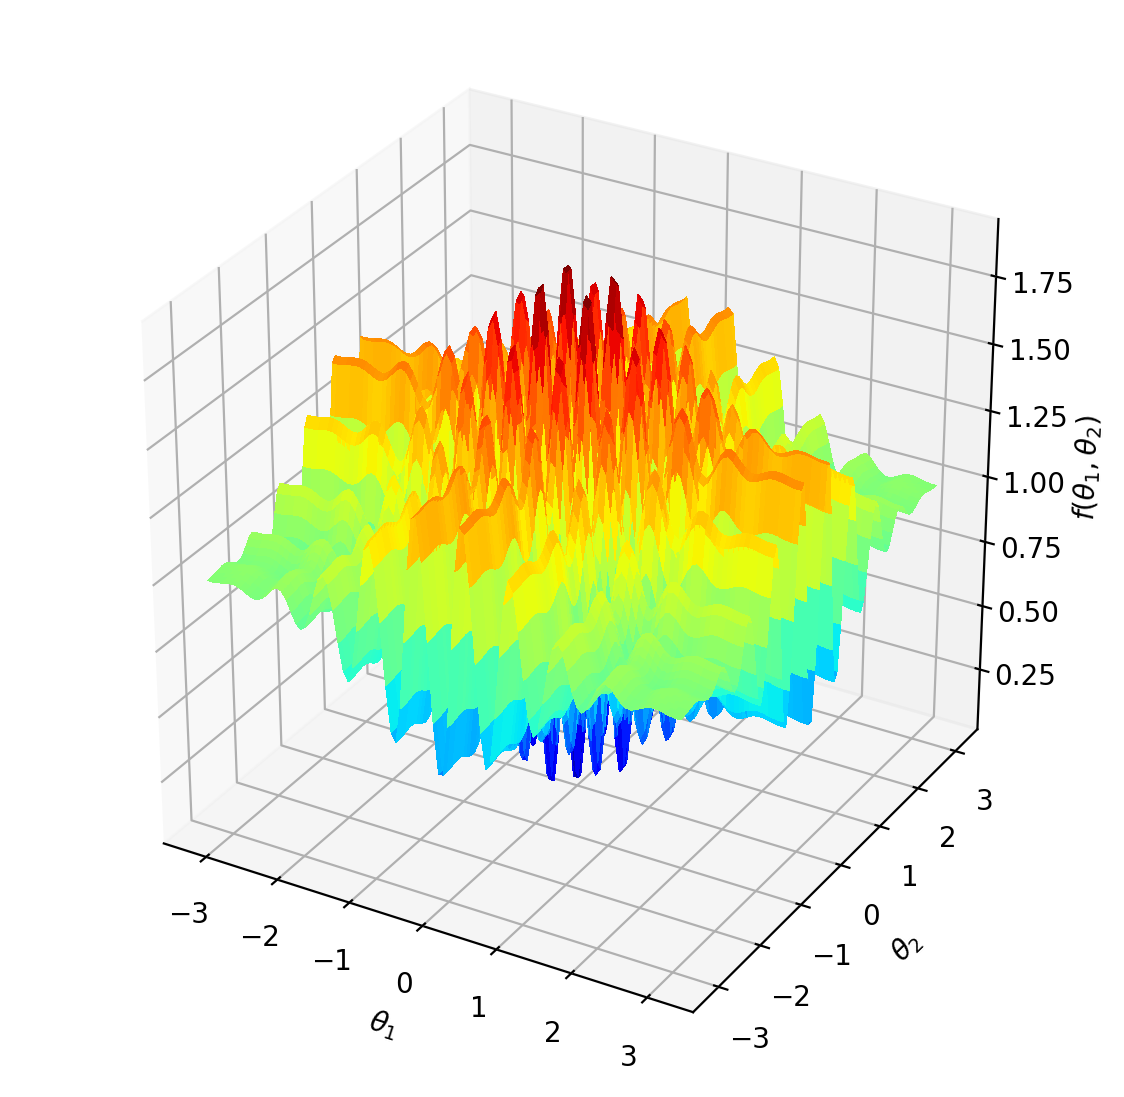

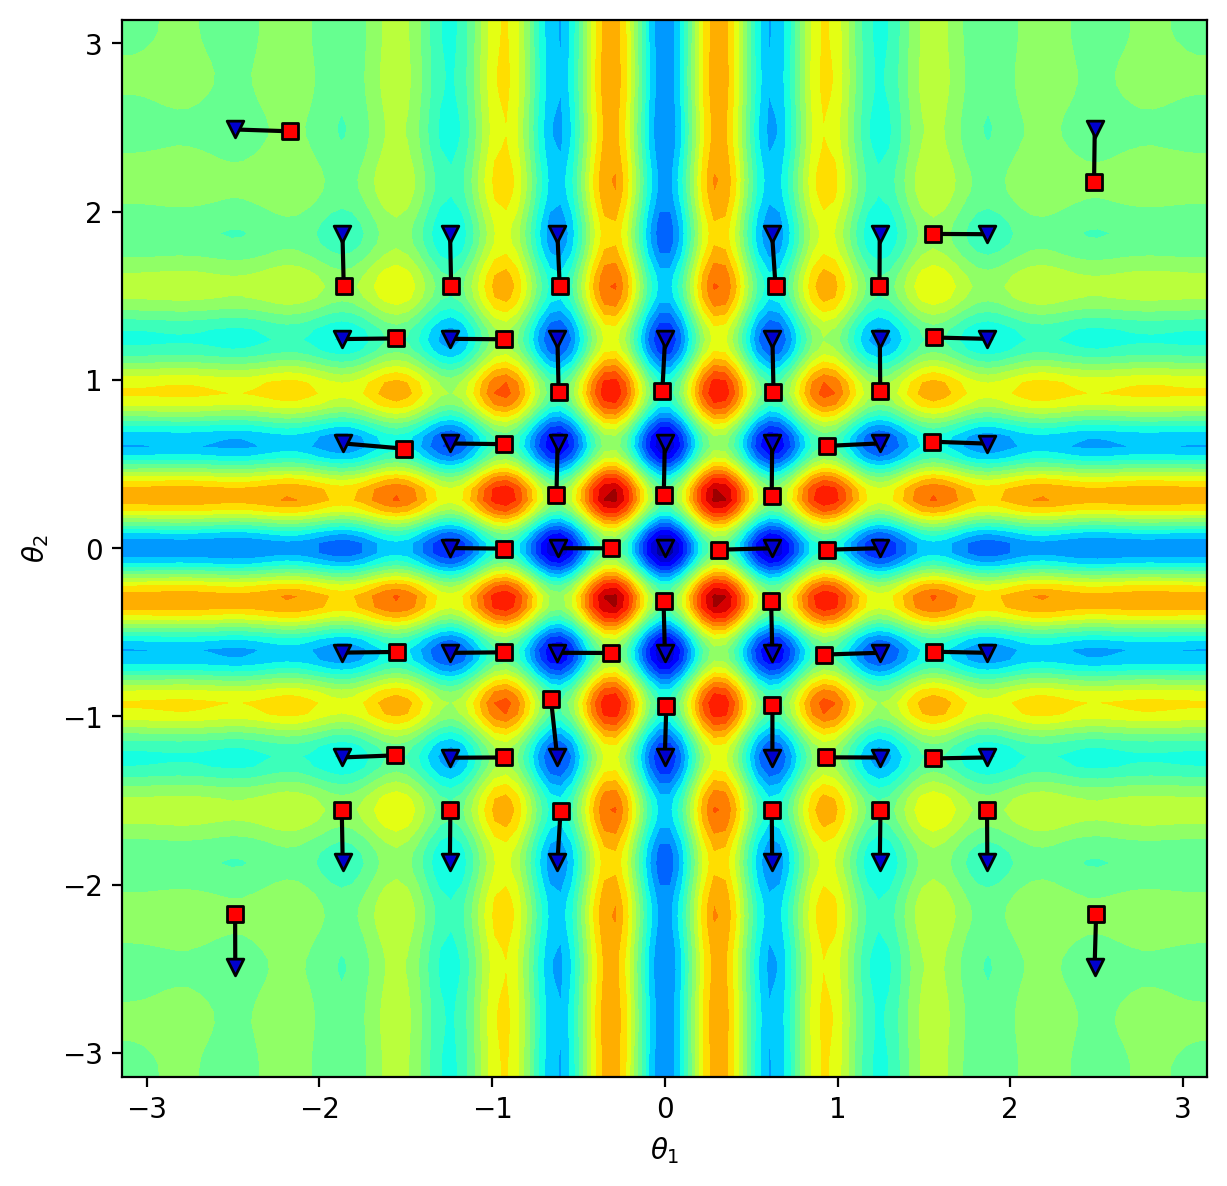

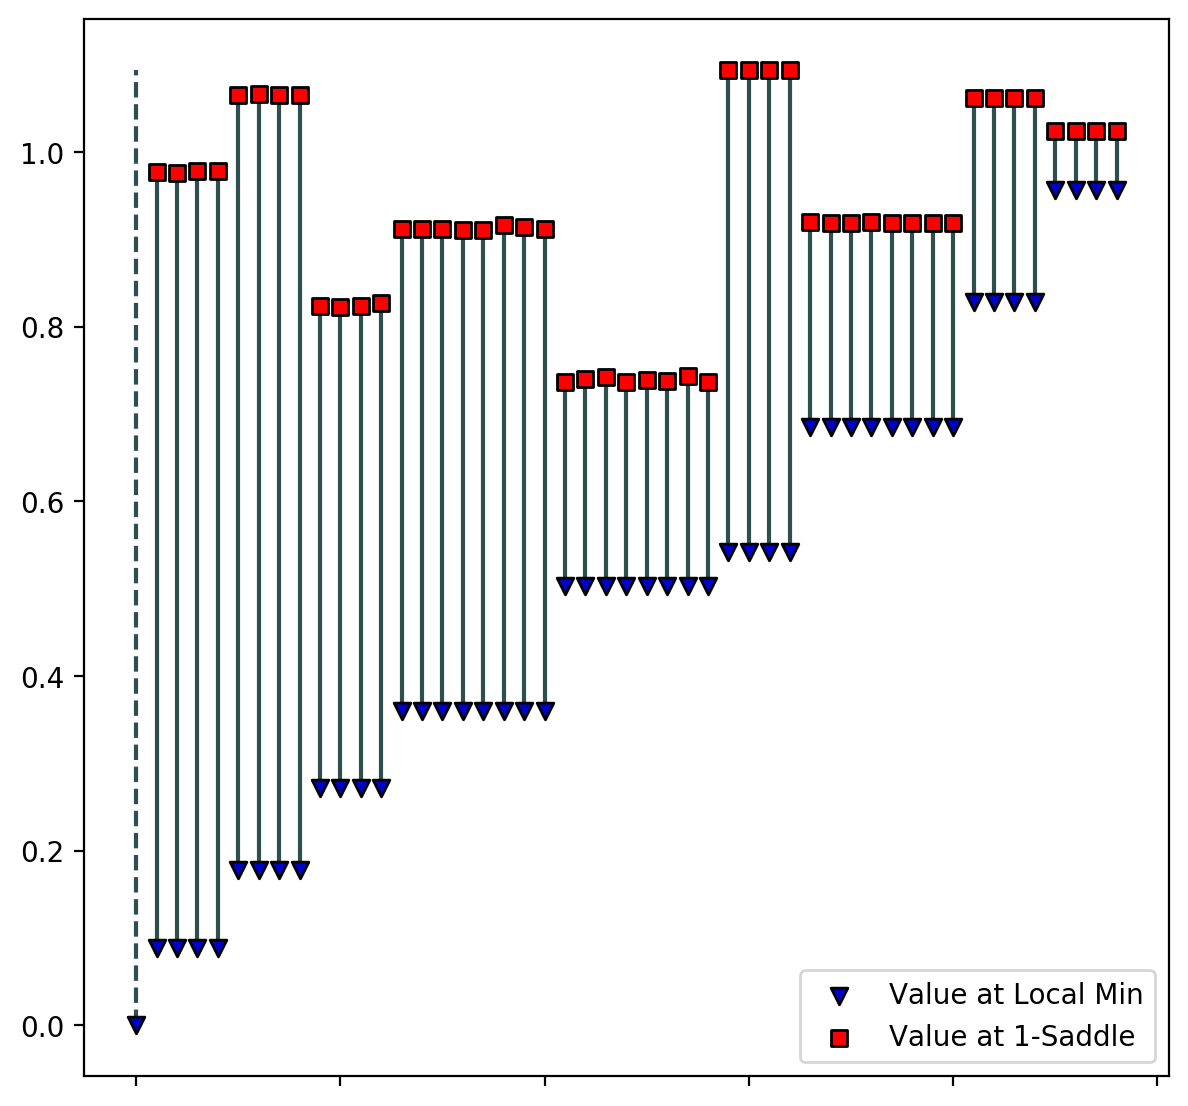

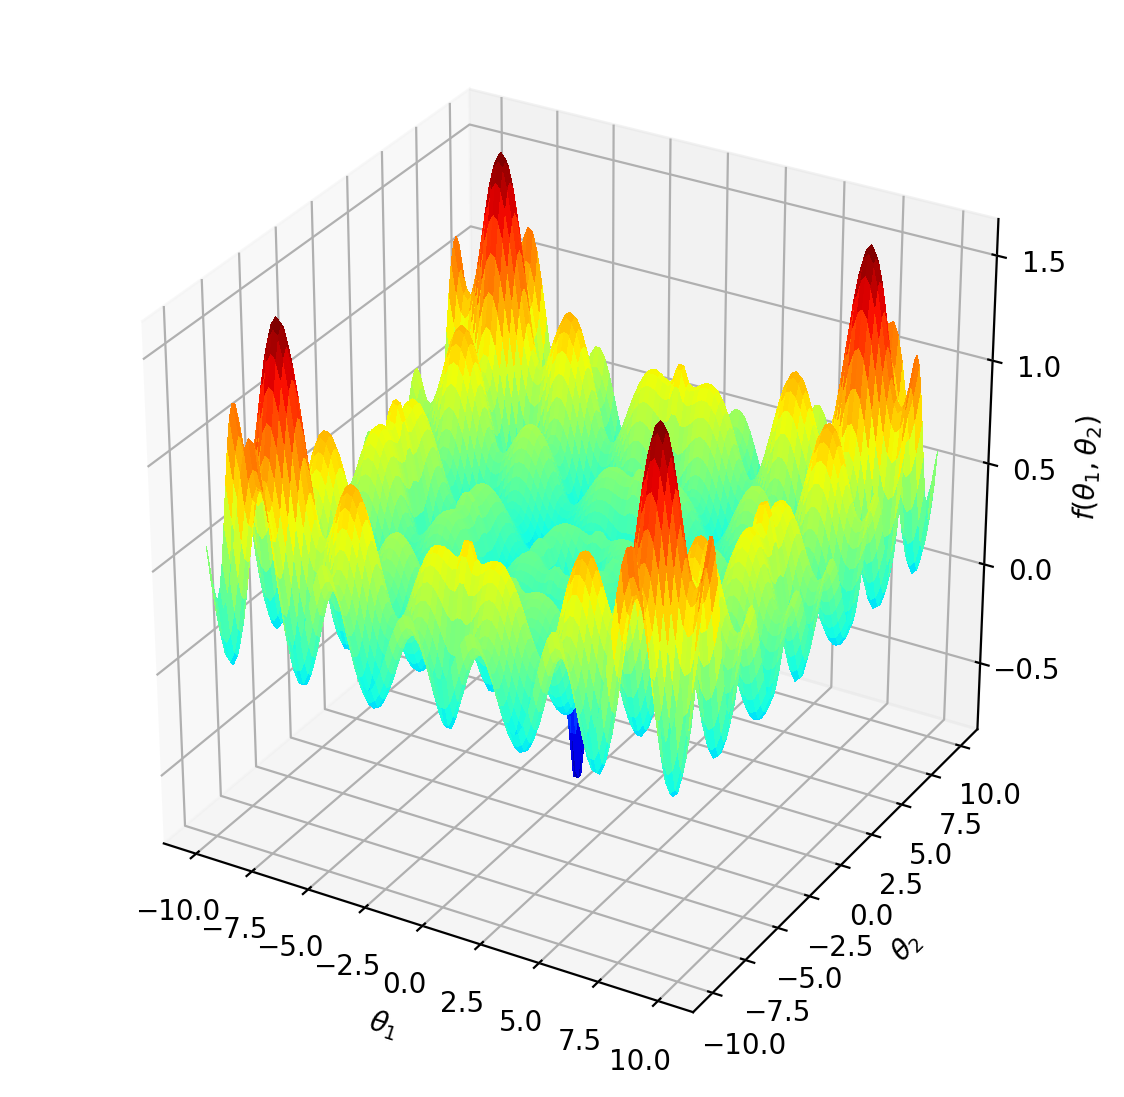

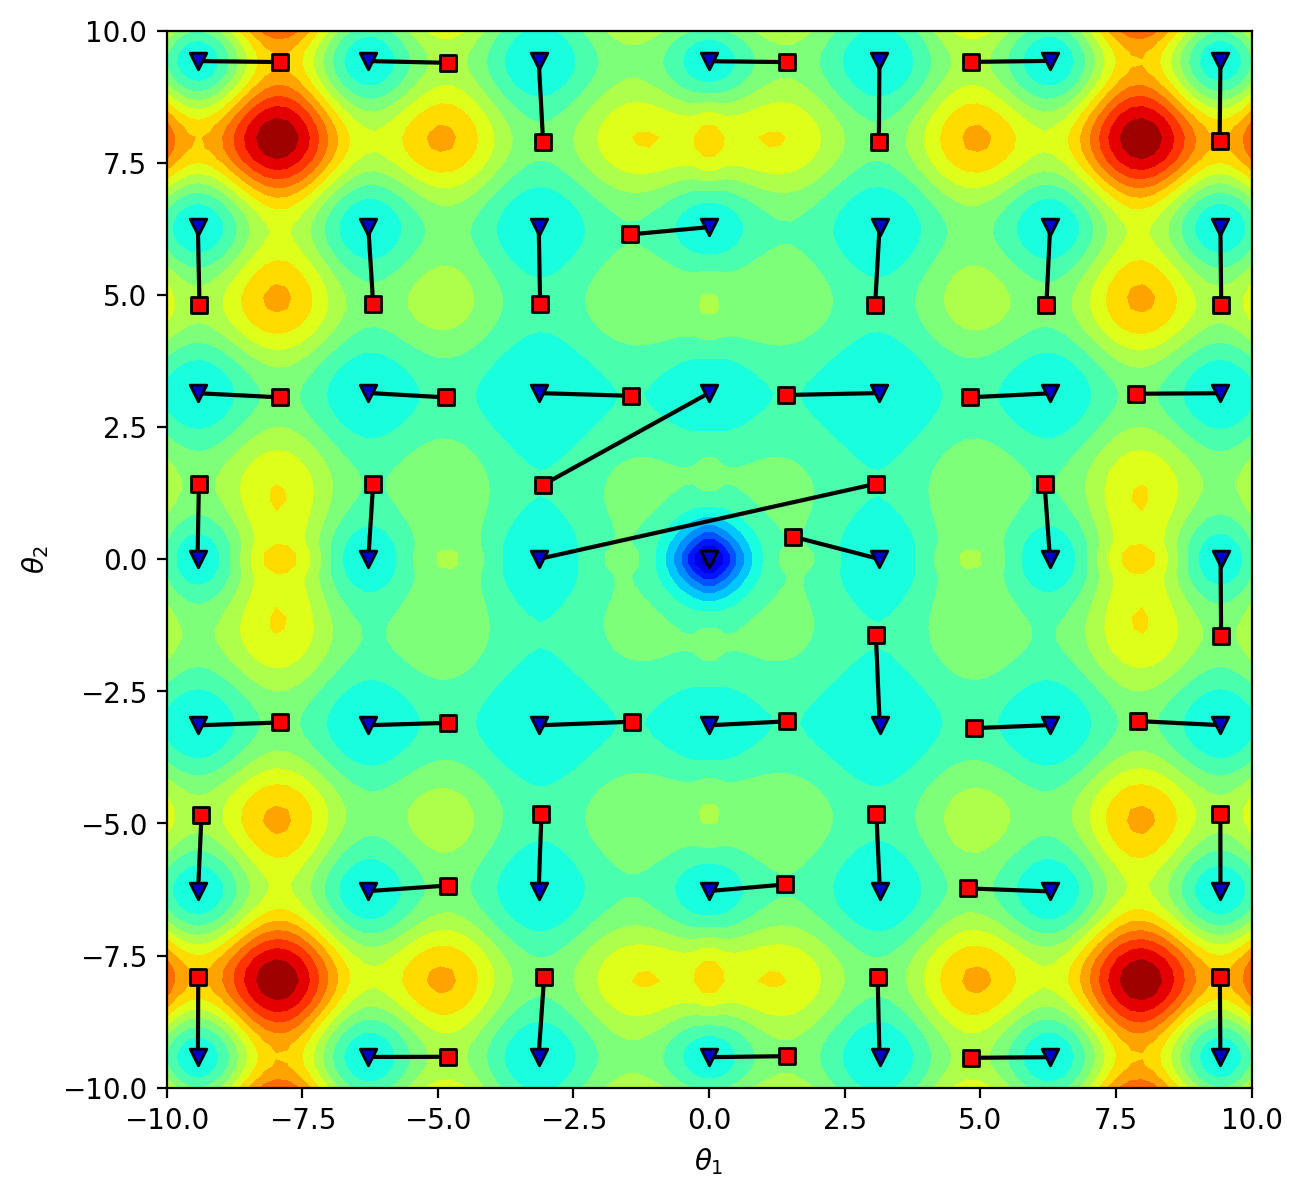

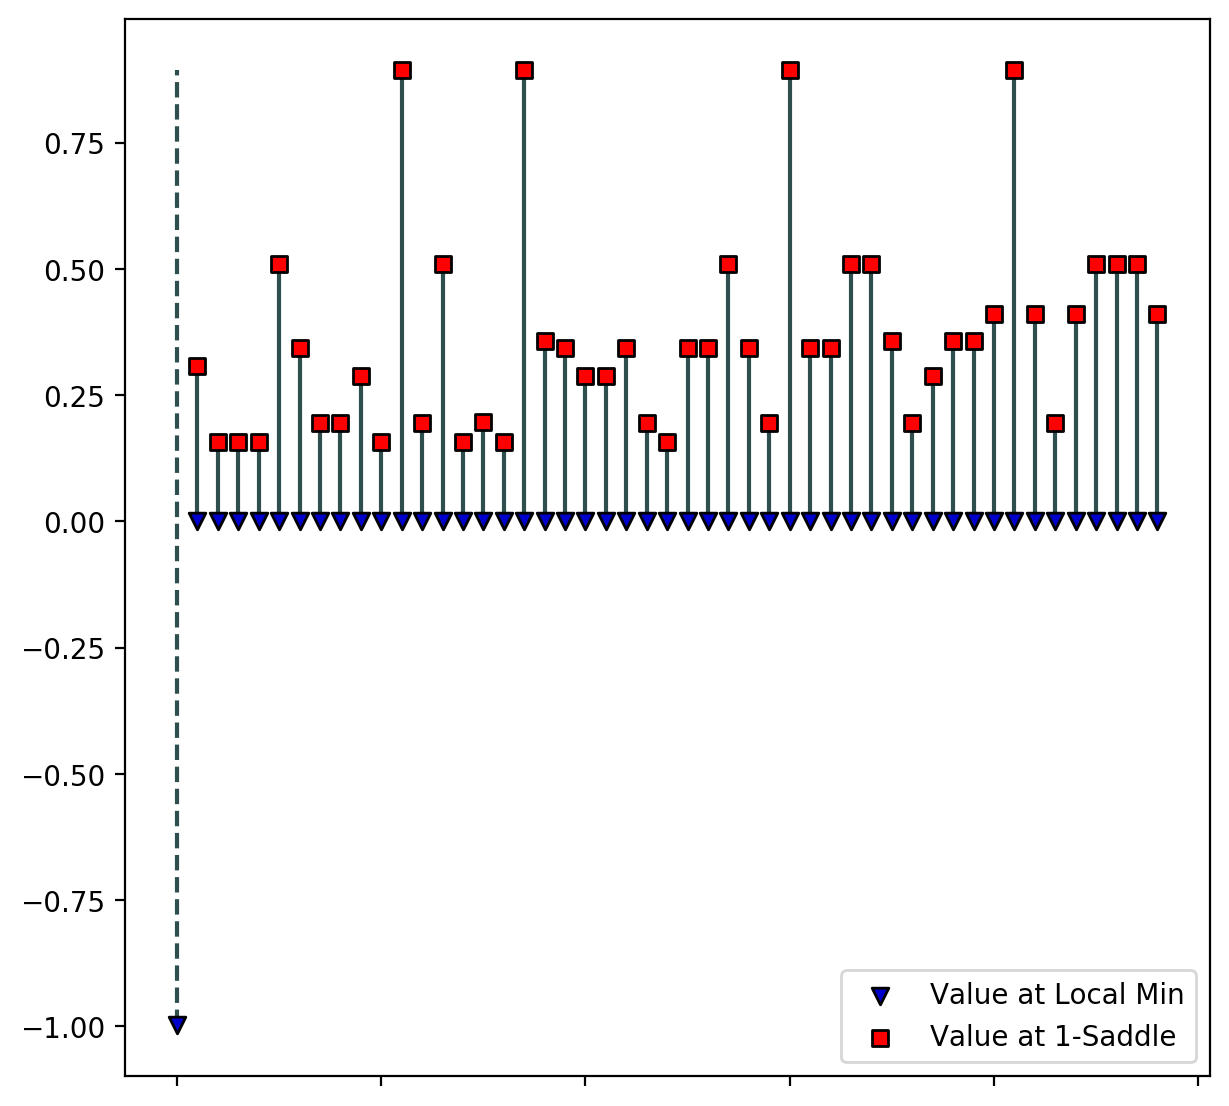

In [5]:
for f, top in tqdm(fs_and_tops):
    x_for_f = np.array(x * (f.bounds[:, 1] - f.bounds[:, 0]) + f.bounds[:, 0], dtype=np.float32)
    
    f_x = f(x_for_f)
#     f_x += np.sum(x_for_f, axis=1) * 0.01 * (np.max(f_x) - np.min(f_x)) / max(f.bounds[0, 1] - f.bounds[0, 0], f.bounds[1, 1] - f.bounds[1, 0])
    f_x = f_x.astype(np.float32)
    result = GetBarcodes(f_x, graph)

    result = pd.DataFrame(result)
    result.columns = [
        'birth', 'death', 'birth_swallowed_cluster',
        'id_dead_min', 'id_saddle', 'id_swallowed_min', 'dead_cluster_size',
        'swallowed_cluster_size', 'mean_height_cluster'
    ]

    result.sort_values('dead_cluster_size', ascending=False, inplace=True)

    min_cluster_size = result.dead_cluster_size.sort_values().values[-top]

    grid_size = 100
    X = np.linspace(*f.bounds[0], grid_size)
    Y = np.linspace(*f.bounds[1], grid_size)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.hstack([X.reshape((-1, 1)), Y.reshape((-1, 1))])).reshape((grid_size, grid_size))

    # Plot the surface.
    fig = plt.figure(figsize=(7, 7), dpi=200)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.jet, rcount=100, ccount=100, linewidth=0, antialiased=False)
    # ax.view_init(elev=30.)
    ax.set_xlabel(r'$\theta_{1}$'); ax.set_ylabel(r'$\theta_{2}$')
    ax.set_zlabel(r'$f(\theta_{1}, \theta_{2})$')
    fig.savefig(os.path.join(OUT_PATH, type(f).__name__ + '_3d.png'))
    plt.show()

    # Plot 2d view.
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=200)
    ax.contourf(X, Y, Z, cmap=cm.jet, levels=20)

    minima = x_for_f[result.id_dead_min[result.dead_cluster_size >= min_cluster_size]]
    saddles = x_for_f[result.id_saddle[result.dead_cluster_size >= min_cluster_size]]
    for i in range(1, len(minima)):
        ax.plot([minima[i, 0], saddles[i, 0]], [minima[i, 1], saddles[i, 1]], color='black', zorder=1)
    ax.scatter(minima[:, 0], minima[:, 1], zorder=np.inf, c='mediumblue', marker="v", edgecolor='black',)
    ax.scatter(saddles[1:, 0], saddles[1:, 1], zorder=np.inf, c='red', edgecolor='black', marker='s',)

    ax.set_xlabel(r'$\theta_{1}$'); ax.set_ylabel(r'$\theta_{2}$')
    ax.set_xlim(f.bounds[0, 0], f.bounds[0, 1])
    ax.set_ylim(f.bounds[1, 0], f.bounds[1, 1])
    fig.savefig(os.path.join(OUT_PATH, type(f).__name__ + '_2d.png'))
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=200)
    plot_barcodes(
        result,
        ax=ax,
        min_cluster_size=min_cluster_size,
    )
    fig.savefig(os.path.join(OUT_PATH, type(f).__name__ + '_barcodes.png'))
    plt.show()